+ Yalidt Díaz
+ Yedam Fotiz

# WGAN

In [1]:
#Librerias
%matplotlib inline

import numpy as np
import time
from numpy import random
from numpy import vstack
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend
from keras.layers import Dropout
from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from tensorflow.keras.backend import mean
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Dropout
from tensorflow.keras.layers import Reshape, Flatten, LeakyReLU, Embedding, Concatenate

In [2]:
# Constants
NROWS = 28
NCOLS = 28
NCHAN = 1

z_dim = 128  #dimensión latente
n_classes = 10

In [3]:
# Load data
(x_train, y_train), (_, _) = mnist.load_data()

# Rescale [0, 255] grayscale pixel values to [-1, 1]
x_train = x_train / 127.5 - 1.
x_train = np.expand_dims(x_train, axis=3)

print(x_train.shape)
print(y_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(60000,)


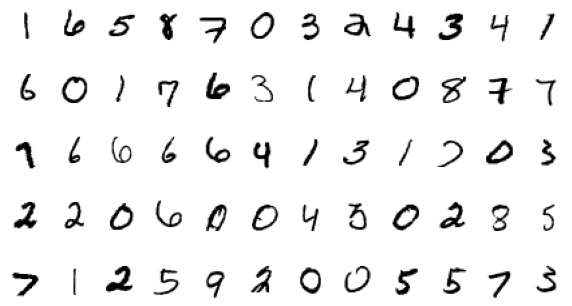

In [4]:
# Looking at some data
plt.figure(figsize=(10,6))
n_digits = 60
select = random.randint(low=0,high=x_train.shape[0],size=n_digits)
for i, index in enumerate(select):  
    plt.subplot(5, 12, i+1)
    plt.imshow(x_train[index].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

Discriminador - Critic (Weight)

In [5]:
class ClipConstraint(Constraint):
    """
    clip model weights to a given hypercube
    """
    def __init__(self, clip_value):
        self.clip_value = clip_value
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)
    def get_config(self):
        return {'clip_value': self.clip_value}

Wasserstein loss

In [6]:
def wasserstein_loss(y_true, y_pred):
    """
    Wasserstein loss function
    """
    return backend.mean(y_true * y_pred)

Discriminador

In [7]:
def create_discriminator(NROWS, NCOLS, NCHAN):
    """
    Define the conv net for the critic
    """
    init = RandomNormal(stddev=0.02)    # weight initialization
    const = ClipConstraint(0.01)    # weight constraint
    model = Sequential()
    model.add(Input(shape=(NROWS, NCOLS, NCHAN + 1)))
  
    model.add(Conv2D(128, 3, strides=2, padding='same', kernel_constraint=const, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, 3, strides=2, padding='same', kernel_constraint=const, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, 3, strides=2, padding='same', kernel_constraint=const, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))

    return model

Number of parameters: 299,649


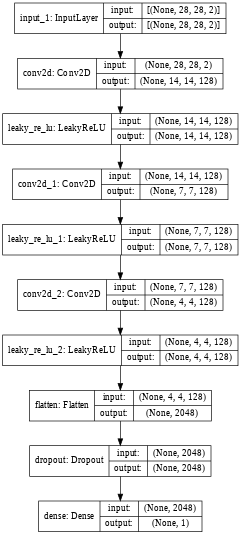

In [8]:
disc = create_discriminator(NROWS, NCOLS, NCHAN)
print(f"Number of parameters: {disc.count_params():,}")
plot_model(disc, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [9]:
def create_cdiscriminator(NROWS, NCOLS, NCHAN, n_classes):
  img = Input(shape=(NROWS, NCOLS, NCHAN), name='x_INPUT')

  c = Input(shape=(1, ), name='c_INPUT')
  c_embedding = Embedding(n_classes, NROWS * NCOLS * NCHAN, input_length=1)(c)
  c_embedding = Reshape((NROWS, NCOLS, NCHAN))(c_embedding)

  concatenated = Concatenate(axis=-1)([img, c_embedding])

  discriminator = create_discriminator(NROWS, NCOLS, NCHAN)
  y = discriminator(concatenated)

  # Model
  model = Model([img, c], y)
  opt = RMSprop(lr=0.00005)    # define optimizer RMS 
  model.compile(loss=wasserstein_loss,optimizer=opt, metrics=['accuracy']) #optimize with loss wasserstein
  return model

Number of parameters: 307,489


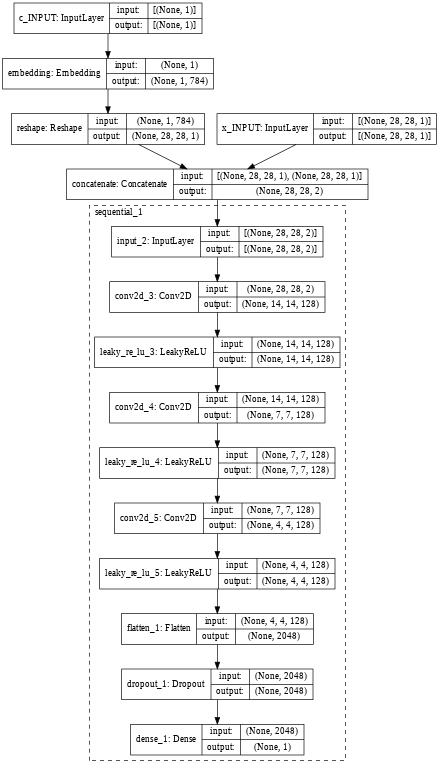

In [10]:
cdisc = create_cdiscriminator(NROWS, NCOLS, NCHAN, 10)
print(f"Number of parameters: {cdisc.count_params():,}")
plot_model(cdisc, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [11]:
def create_generator(z_dim):
  model = Sequential()
  model.add(Input(shape=(4, 4, z_dim + 1,)))
  init = RandomNormal(stddev=0.02)    # weight initialization
  
  model.add(Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, 3))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer=init))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(1, 7, padding='same', activation='tanh',  kernel_initializer=init))

  return model

Number of parameters: 944,257


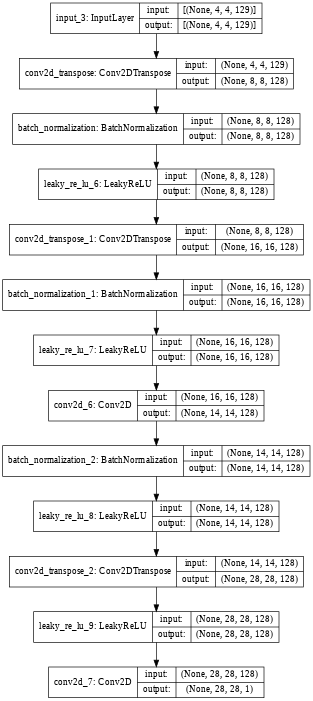

In [12]:
gene = create_generator(z_dim)
print(f"Number of parameters: {gene.count_params():,}")
plot_model(gene, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [13]:
def create_cgenerator(z_dim, n_classes):
  z_in = Input(shape=(z_dim, ), name='z_INPUT')
  z = Dense(4 * 4 * z_dim)(z_in)
  z = LeakyReLU(0.2)(z)
  z = Reshape((4, 4, z_dim))(z)

  c_in = Input(shape=(1, ), name='c_INPUT')
  c = Embedding(n_classes, z_dim, input_length=1)(c_in)
  c = Dense(4 * 4)(c)
  c = Reshape((4, 4, 1))(c)

  concatenated = Concatenate(axis=-1)([z, c])

  generator = create_generator(z_dim)
  c_img = generator(concatenated) # x_hat

  return Model([z_in, c_in], c_img)

Number of parameters: 1,211,793


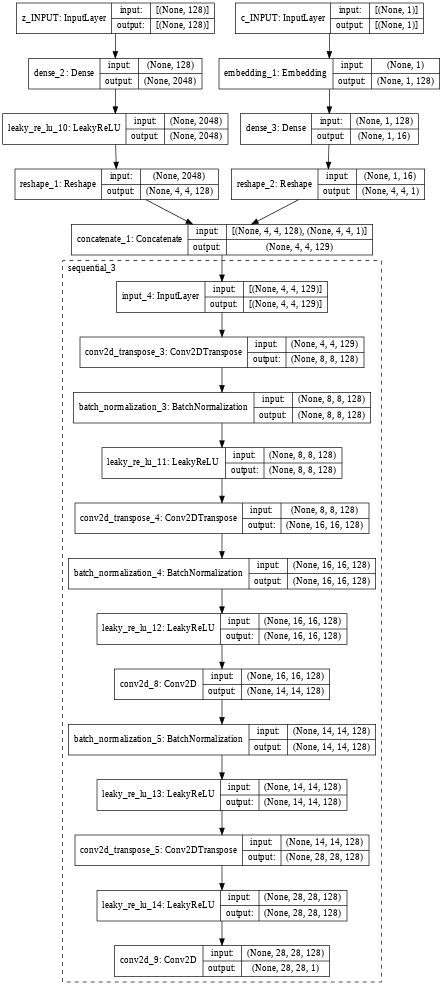

In [14]:
cgene = create_cgenerator(z_dim, n_classes)
print(f"Number of parameters: {cgene.count_params():,}")
plot_model(cgene, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [15]:
del disc, cdisc, gene, cgene

Create Wgan

In [16]:
def create_wgan(cgenerator, cdiscriminator):
  cdiscriminator.trainable = False     # make weights in the critic not trainable

  gen_noise, gen_label = cgenerator.input #(None, 128) and (None, 1)
  gen_output = cgenerator.output #(None, 28, 28, 1)
  
  gan_output = cdiscriminator([gen_output, gen_label])
  model = Model([gen_noise, gen_label], gan_output)
  opt = RMSprop(lr=0.00005)
  model.compile(loss=wasserstein_loss, optimizer=opt)
  return model

def create_cgan(cgenerator, cdiscriminator): 
  cdiscriminator.trainable = False

  gen_noise, gen_label = cgenerator.input #(None, 128) and (None, 1)
  gen_output = cgenerator.output #(None, 28, 28, 1)
  
  gan_output = cdiscriminator([gen_output, gen_label])
  
  model = Model([gen_noise, gen_label], gan_output)
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
  
  return model

Number of parameters: 1,519,282


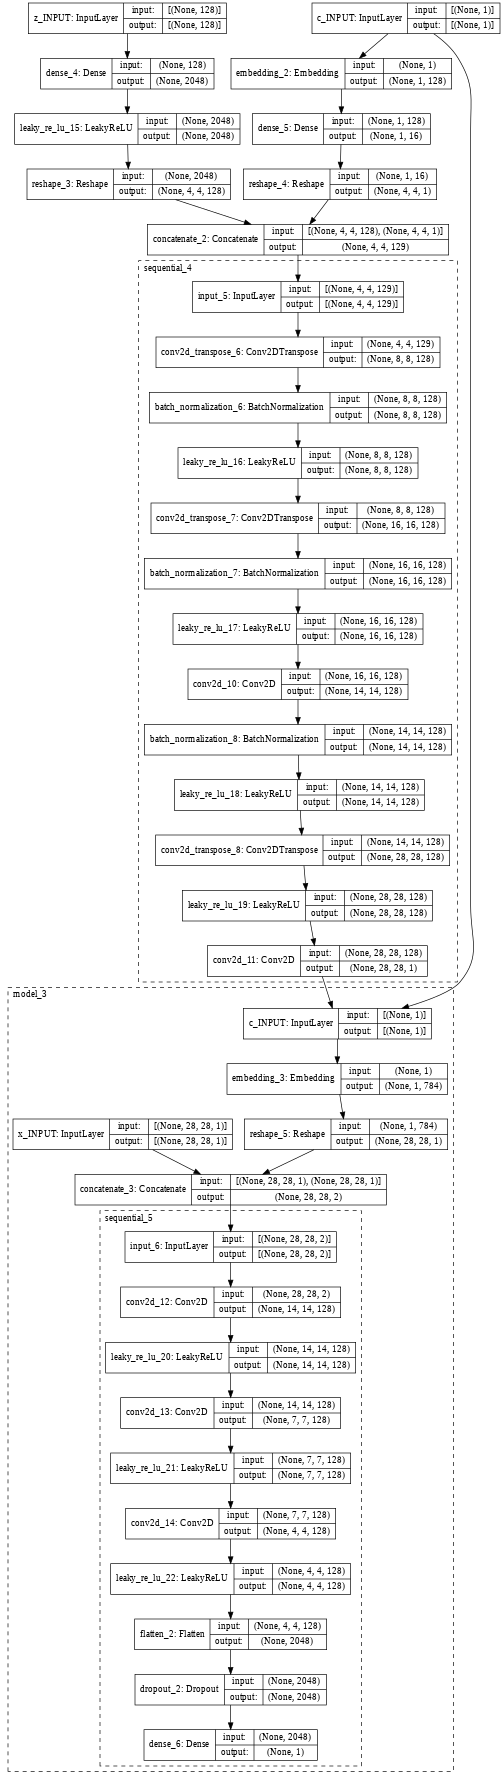

In [17]:
cgene = create_cgenerator(z_dim, n_classes)
cdisc = create_cdiscriminator(NROWS, NCOLS, NCHAN, 10)
#CGAN = create_cgan(cgene, cdisc)
WGAN = create_wgan(cgene, cdisc)
print(f"Number of parameters: {WGAN.count_params():,}")
plot_model(WGAN, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [18]:
def train(X, y, params):
  # Unzip parameters
  n_epochs = params['n_epochs']
  batch_size = params['batch_size']
  sample_interval = params['sample_interval']
  z_dim = params['z_dim']
  n_critic = params['n_critic']

  # Performance storage
  accuracies = []
  losses = []

  # Labels for real and fake images
  real = -1 *np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))
  
  for epoch in range(n_epochs):

    for i in range(n_critic):
      # -- Train Discriminator
      # Get a random batch of real images and their labels
      idx = np.random.randint(0, X.shape[0], batch_size)
      imgs, labels = X[idx], y[idx]

      # Generate a batch of fake images
      z = np.random.normal(0, 1, (batch_size, z_dim))
      gen_imgs = cgene.predict([z, labels])

      # Training
      d_loss_real = cdisc.train_on_batch([imgs, labels], real)
      d_loss_fake = cdisc.train_on_batch([gen_imgs, labels], fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


    z = np.random.normal(0, 1, (batch_size, z_dim))

    # Get a batch of random labels
    #labels = np.random.randint(0, n_classes, batch_size).reshape(-1, 1)

    # Training
    g_loss = WGAN.train_on_batch([z, labels], real)
      
    if (epoch % sample_interval) == 0:
      
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss[0], g_loss))
      accuracies.append(100 * d_loss[1])

      # Output sample of generated images
      sample_images(z_dim)
      
  return losses, accuracies

In [19]:
def train(X, y, params):
  # Unzip parameters
  n_epochs = params['n_epochs']
  batch_size = params['batch_size']
  sample_interval = params['sample_interval']
  z_dim = params['z_dim']

  n_critic = params['n_critic']

  # Performance storage
  accuracies = []
  losses = []
  d_hist = []

  # Labels for real and fake images
  real = -1*np.ones((batch_size, 1))
  fake = np.ones((batch_size, 1))

  for epoch in range(n_epochs):
    
    d_tmp = 0
    for i in range(n_critic):
      # -- Train Discriminator
      # Get a random batch of real images and their labels
      idx = np.random.randint(0, X.shape[0], batch_size)
      imgs, labels = X[idx], y[idx]

      # Generate a batch of fake images
      z = np.random.normal(0, 1, (batch_size, z_dim))
      gen_imgs = cgene.predict([z, labels])

      # Training
      d_loss_real = cdisc.train_on_batch([imgs, labels], real)
      d_loss_fake = cdisc.train_on_batch([gen_imgs, labels], fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      d_tmp = np.add(d_loss, d_tmp)
      #d_loss = reduce_mean(d_loss_real - d_loss_fake)

    
    d_loss = np.divide(d_tmp, n_critic)
    d_hist.append(d_loss)
    # -- Train Generator
    # Generate a batch of noise vectors
    z = np.random.normal(0, 1, (batch_size, z_dim))

    # Get a batch of random labels
    #labels = np.random.randint(0, n_classes, batch_size).reshape(-1, 1)

    # Training
    g_loss = WGAN.train_on_batch([z, labels], real)

    if (epoch % sample_interval) == 0:
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss[0], g_loss))
      accuracies.append(100 * d_loss[1])

      # Output sample of generated images
      sample_images(z_dim)

  return losses, accuracies

In [20]:
def sample_images(z_dim):
  z = np.random.normal(0, 1, (2 * 5, z_dim))
  labels = np.arange(0, 10).reshape(-1, 1)

  # Generate images from random noise
  gen_imgs = cgene.predict([z, labels])
  gen_imgs = 0.5 * gen_imgs + 0.5

  ind = 0
  fig, axs = plt.subplots(2, 5, figsize=(10, 4), sharey=True, sharex=True)
  for i in range(2):
    for j in range(5):
      axs[i, j].imshow(gen_imgs[ind, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      axs[i, j].set_title("Digit: %d" % labels[ind])
      ind += 1
  plt.show()

0 [D loss: -0.001709, acc.: 0.00%] [G loss: -0.000677]


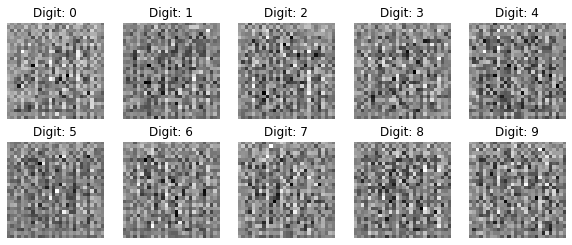

1000 [D loss: 0.095161, acc.: 50.00%] [G loss: -3.595278]


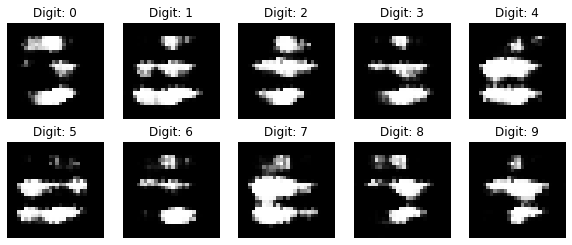

2000 [D loss: -0.056226, acc.: 50.00%] [G loss: -1.596957]


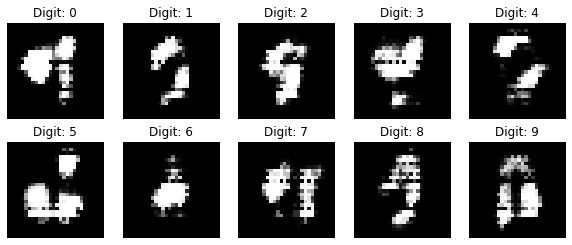

3000 [D loss: -0.111402, acc.: 50.00%] [G loss: -1.426304]


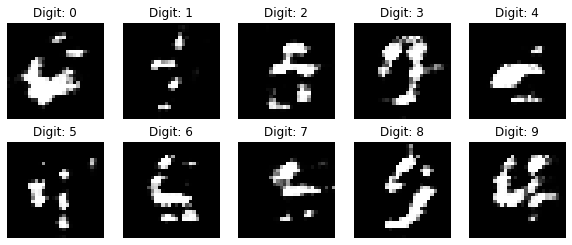

4000 [D loss: -0.095591, acc.: 49.38%] [G loss: -1.485510]


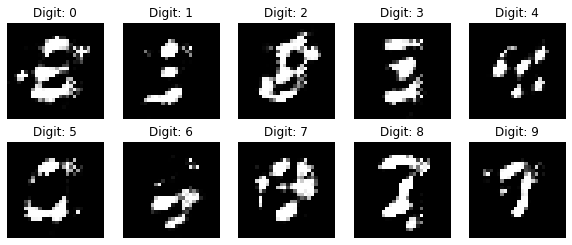

5000 [D loss: -0.093977, acc.: 43.75%] [G loss: -0.671611]


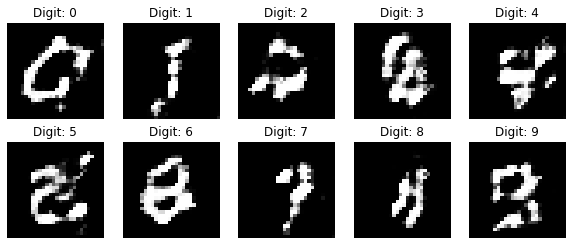

6000 [D loss: -0.160639, acc.: 36.88%] [G loss: -0.727503]


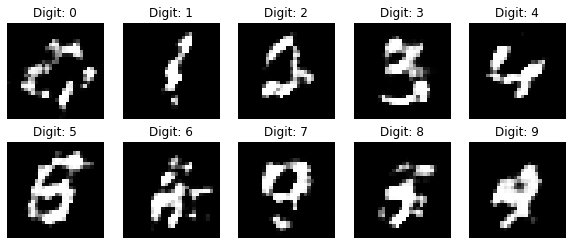

7000 [D loss: -0.078481, acc.: 28.12%] [G loss: -0.455817]


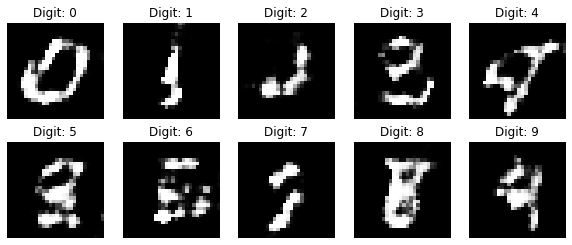

8000 [D loss: -0.002792, acc.: 33.75%] [G loss: -0.652055]


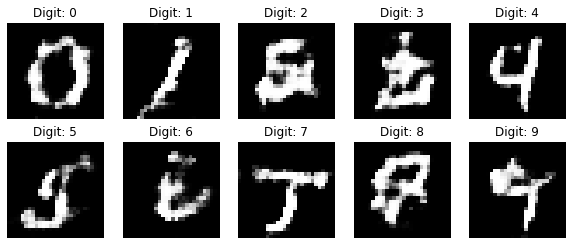

9000 [D loss: -0.110957, acc.: 34.38%] [G loss: -0.645509]


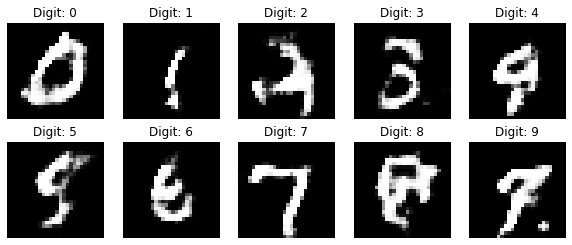

10000 [D loss: -0.096782, acc.: 26.88%] [G loss: -0.601055]


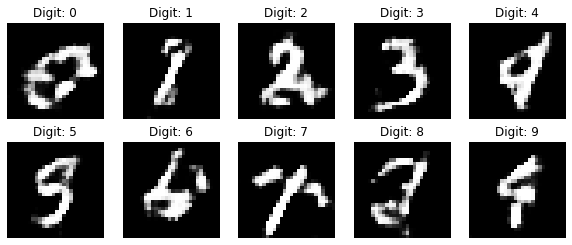

11000 [D loss: -0.100787, acc.: 27.50%] [G loss: -0.479107]


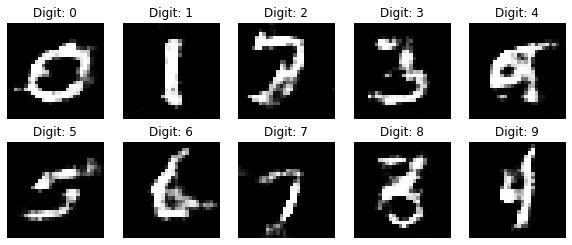

12000 [D loss: -0.067742, acc.: 35.00%] [G loss: -0.676011]


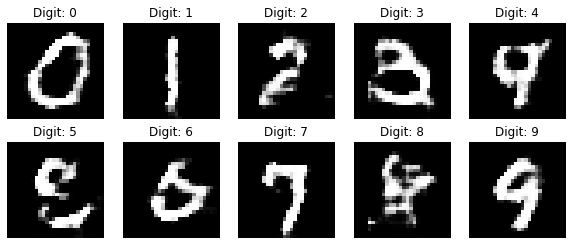

13000 [D loss: -0.095184, acc.: 24.38%] [G loss: -0.403291]


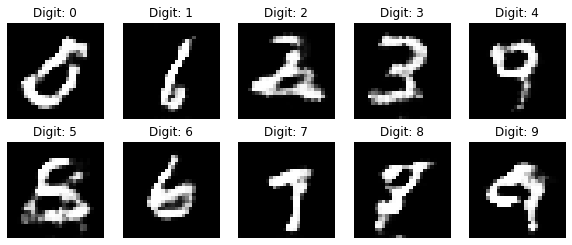

14000 [D loss: -0.055368, acc.: 33.12%] [G loss: -0.511858]


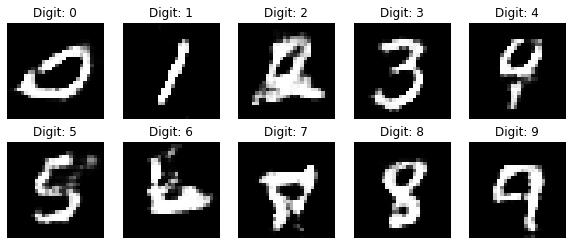

15000 [D loss: -0.056658, acc.: 31.87%] [G loss: -0.509522]


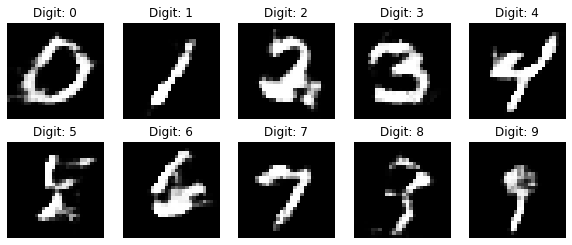

16000 [D loss: -0.047446, acc.: 34.38%] [G loss: -0.563798]


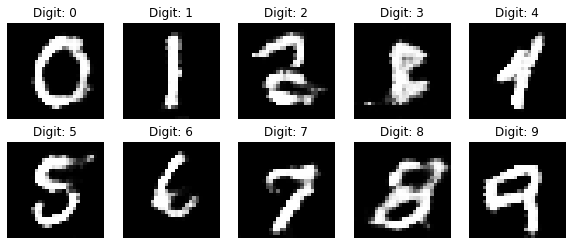

17000 [D loss: -0.003547, acc.: 33.75%] [G loss: -0.569247]


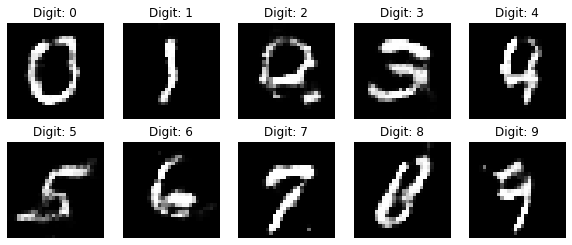

18000 [D loss: -0.036013, acc.: 37.50%] [G loss: -0.875805]


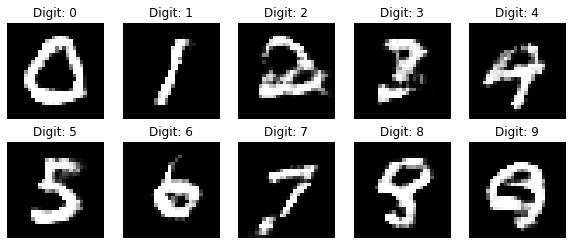

19000 [D loss: -0.086096, acc.: 32.50%] [G loss: -0.740191]


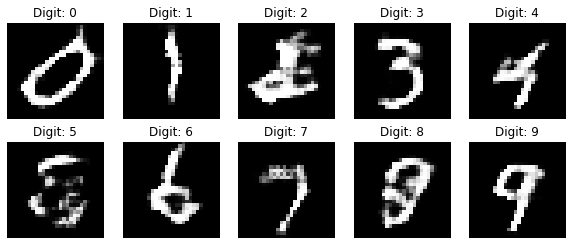

6509.574879646301


In [21]:
# Set some hyperparameters
params = {
    'n_epochs': 20000,
    'batch_size': 16,
    'sample_interval': 1000,
    'z_dim': z_dim,
    'n_critic': 5
}

start_time = time.time()
# Train the WGAN for the specified number of iterations
losses, accuracies = train(x_train, y_train, params)

time_exec = time.time() - start_time
print(time_exec)

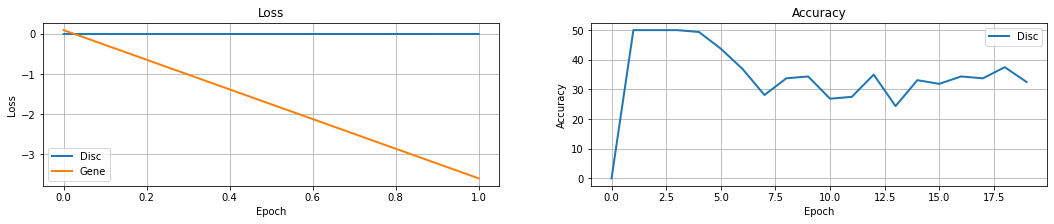

In [22]:
# Plot loss
plt.figure(figsize=(18, 3))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(losses[0], label='Disc', linewidth=2)
plt.plot(losses[1], label='Gene', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(accuracies, label='Disc', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

Intentos anteriores

In [26]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [27]:
def create_discriminator(NROWS, NCOLS, NCHAN):
    """
    Define the conv net for the critic
    """
    init = RandomNormal(stddev=0.02)    # weight initialization
    const = ClipConstraint(0.01)    # weight constraint
    model = Sequential()
    model.add(Input(shape=(NROWS, NCOLS, NCHAN + 1)))
  
    model.add(Conv2D(128, 3, strides=2, padding='same', kernel_initializer=init, kernel_constraint=const))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, 3, strides=2, padding='same', kernel_initializer=init, kernel_constraint=const))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, 3, strides=2, padding='same', kernel_initializer=init, kernel_constraint=const))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid',kernel_initializer=init))

    return model

0 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


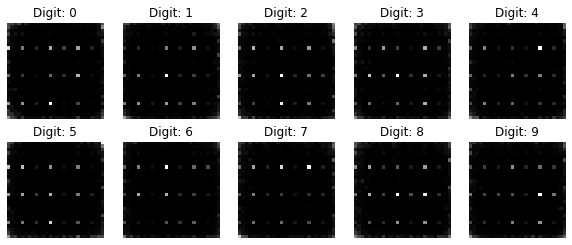

10 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


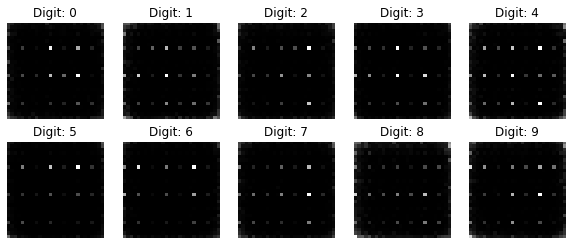

20 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


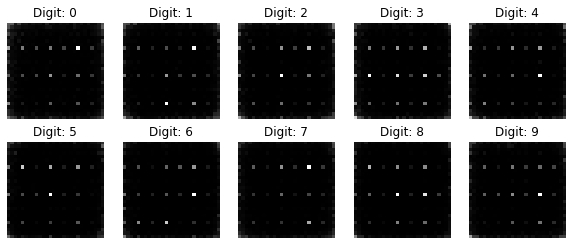

30 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


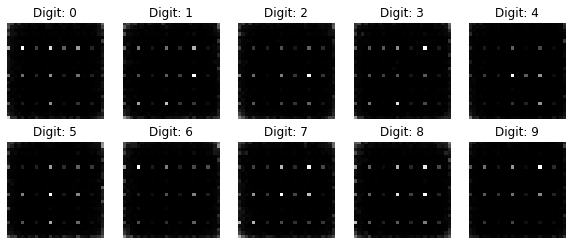

40 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


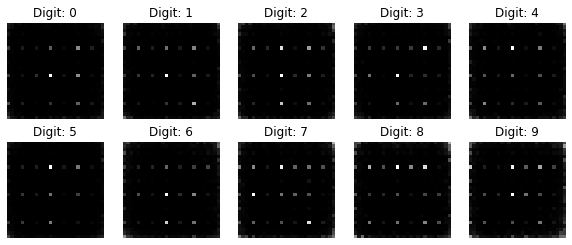

50 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


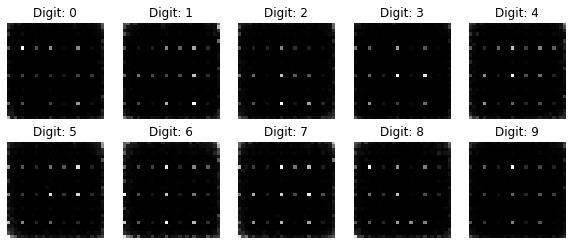

60 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


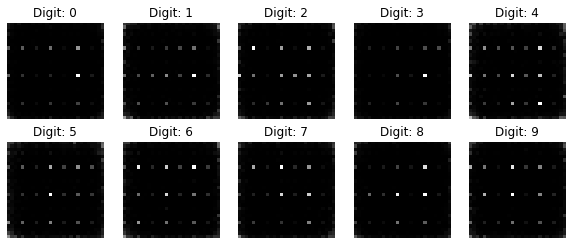

70 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


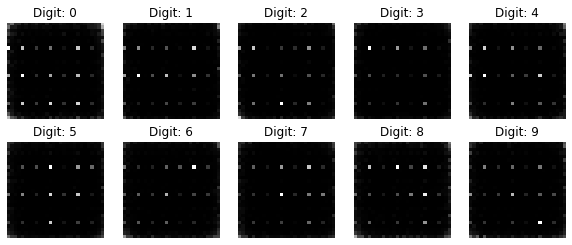

80 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


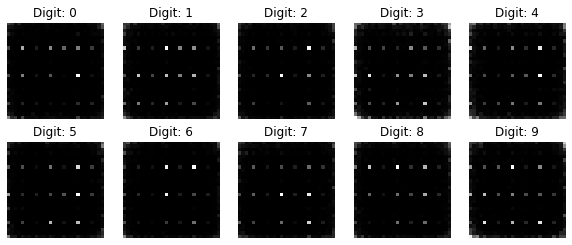

90 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


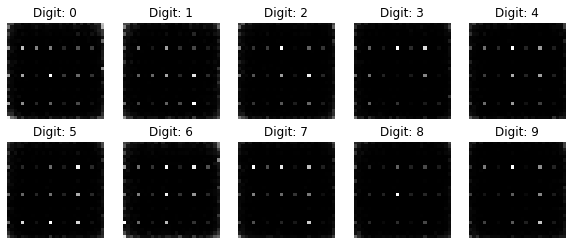

100 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


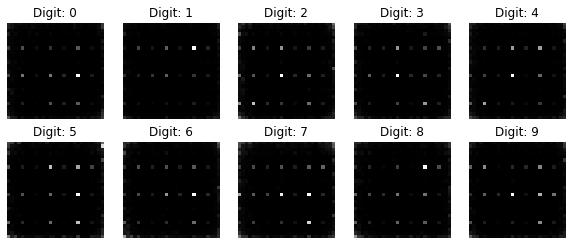

110 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


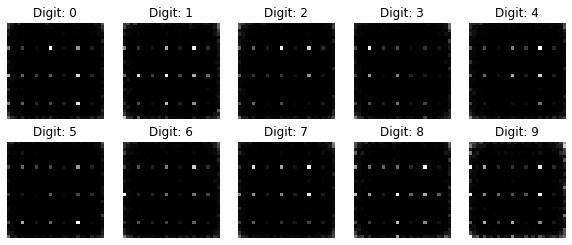

120 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


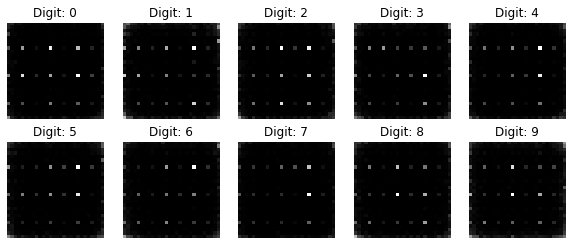

130 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


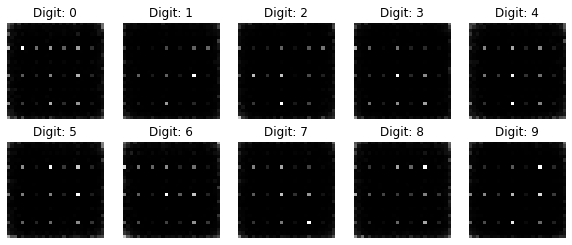

140 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


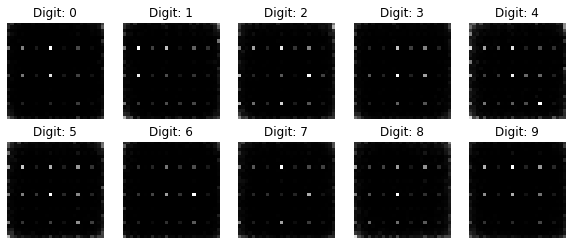

150 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


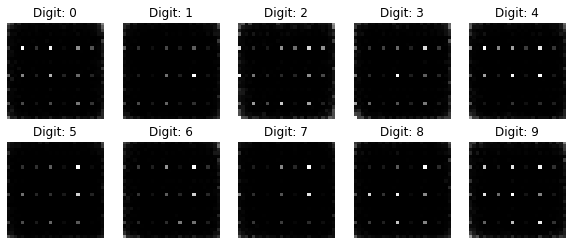

160 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


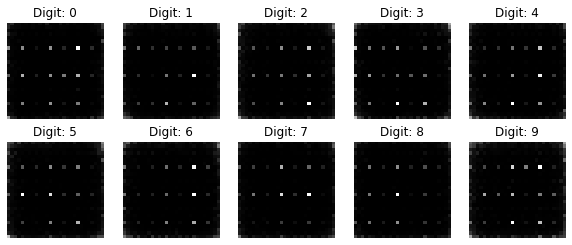

170 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


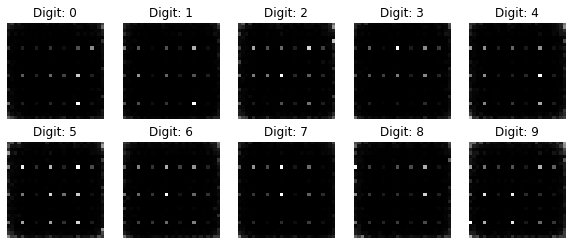

180 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


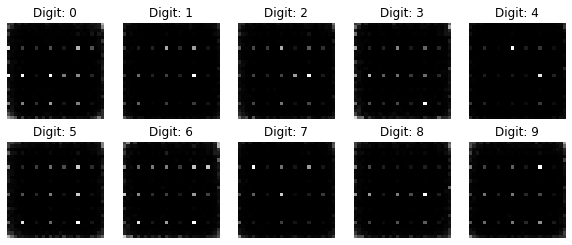

190 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


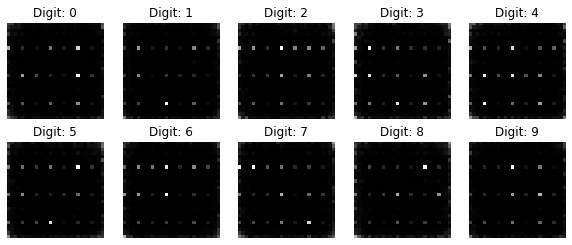

200 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


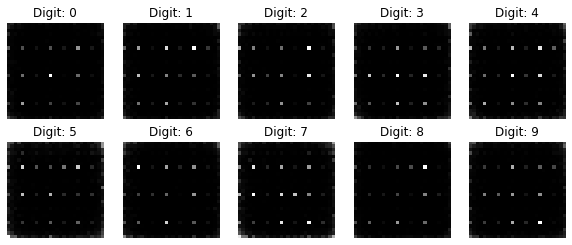

210 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


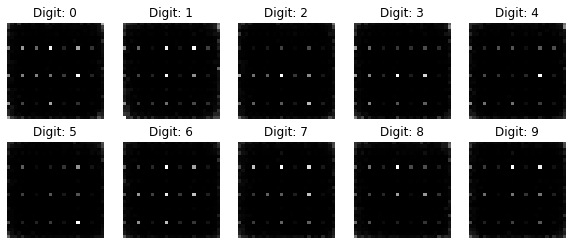

220 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


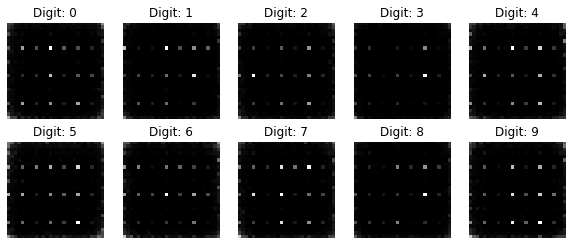

230 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


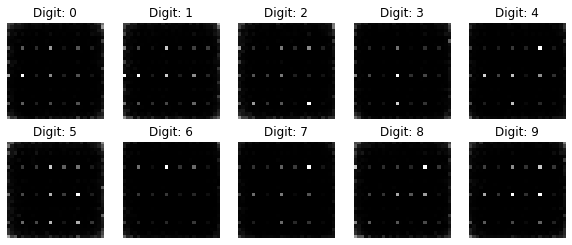

240 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


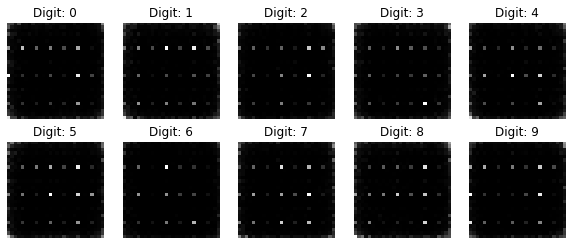

250 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


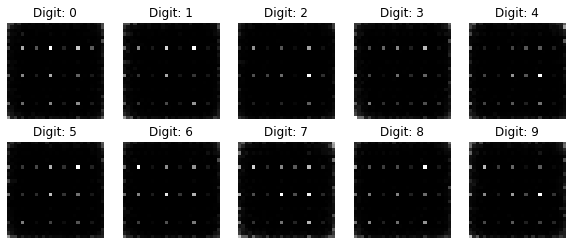

260 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


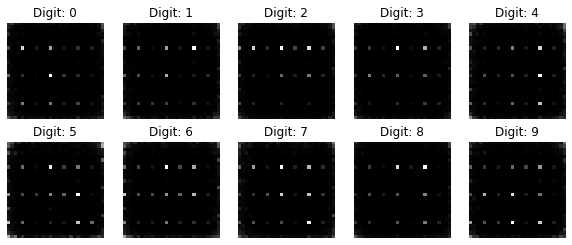

270 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


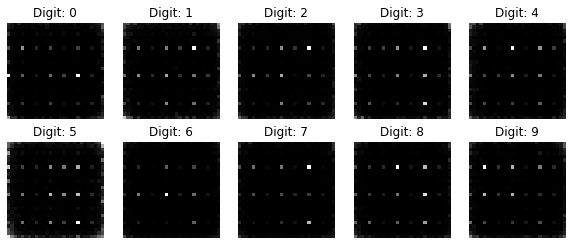

280 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


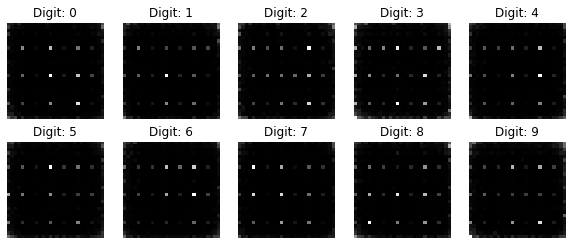

290 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


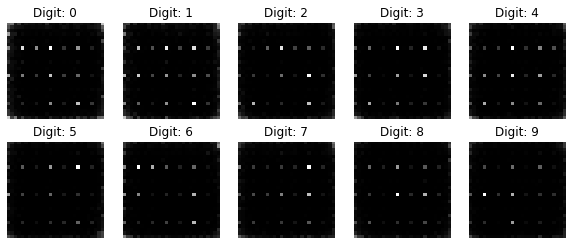

300 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


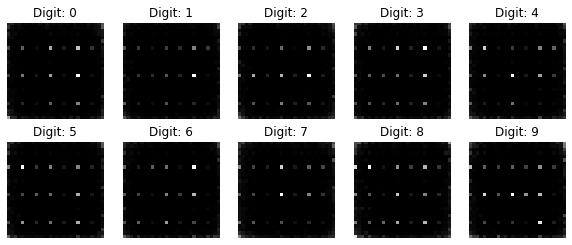

310 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


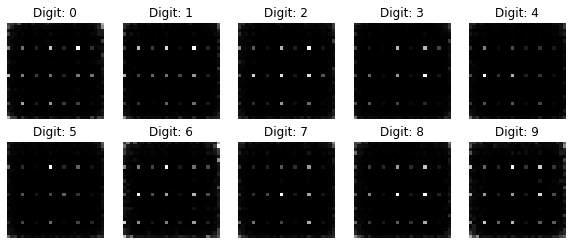

320 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


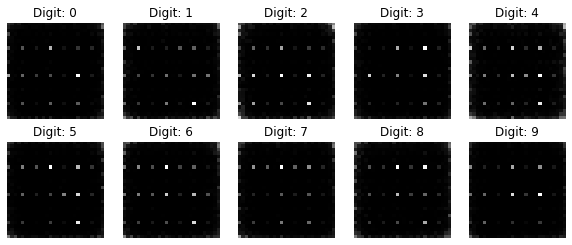

330 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


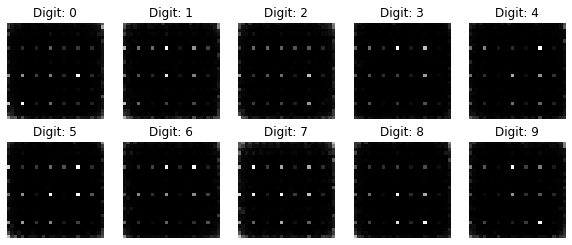

340 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


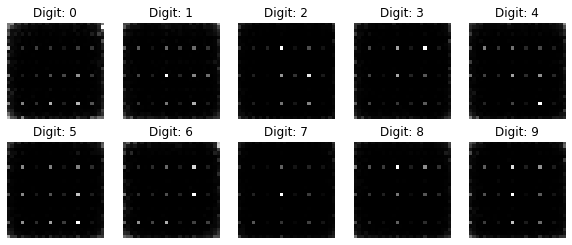

350 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


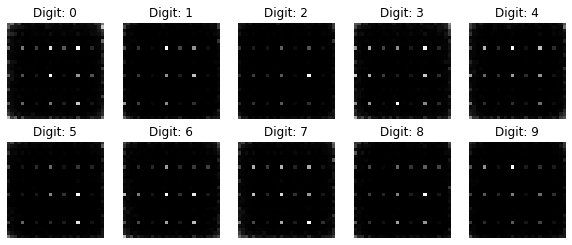

360 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


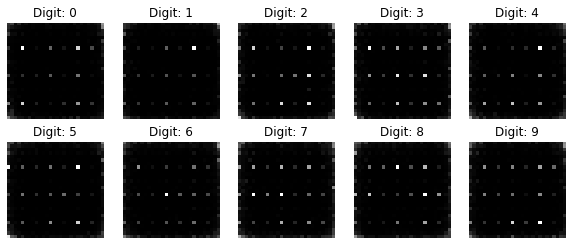

370 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


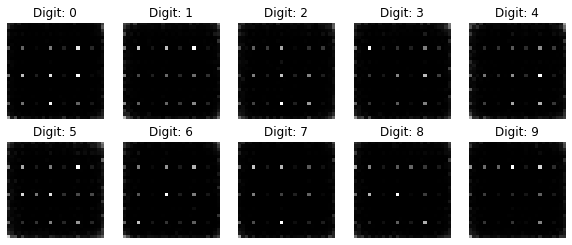

380 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


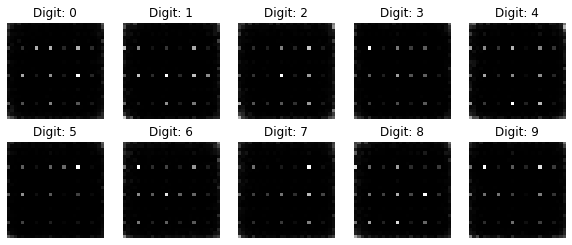

390 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


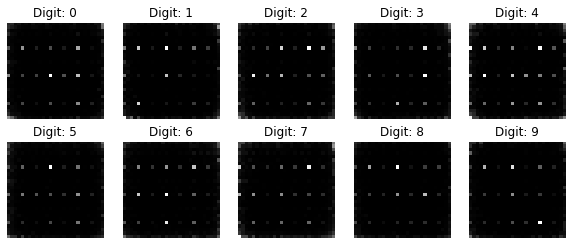

400 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


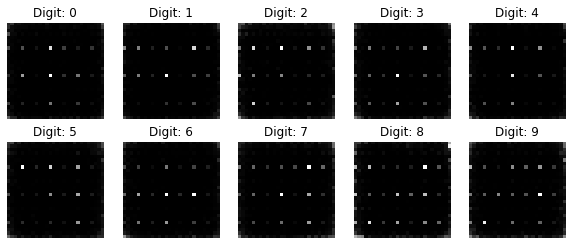

410 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


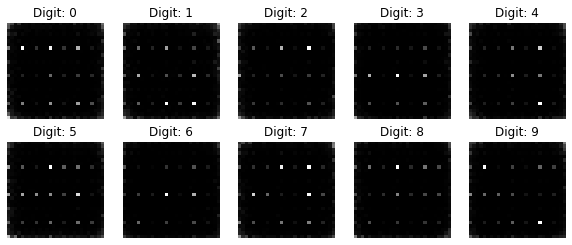

420 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


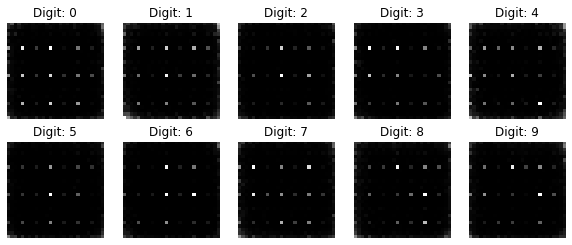

430 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


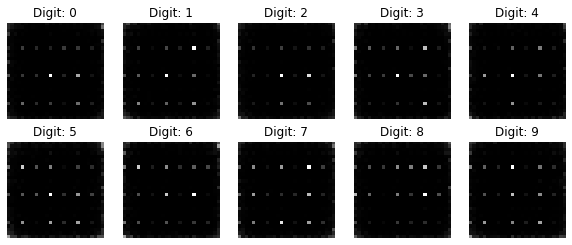

440 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


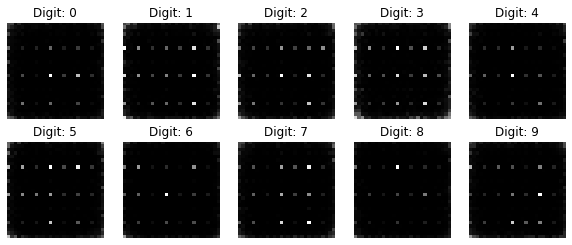

450 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


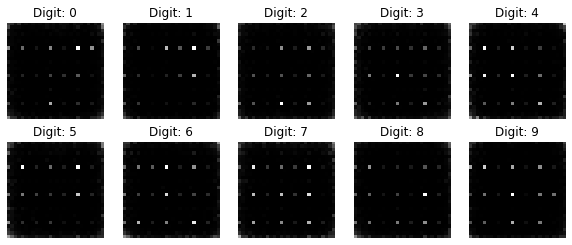

460 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


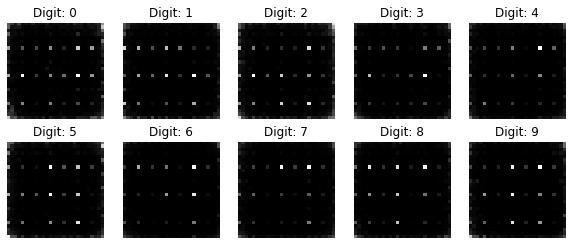

470 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


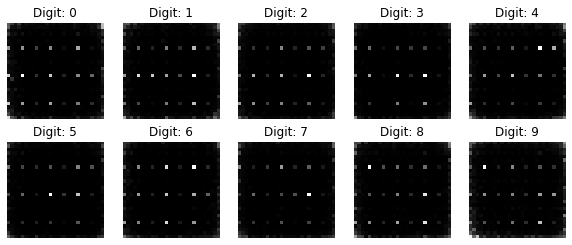

480 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


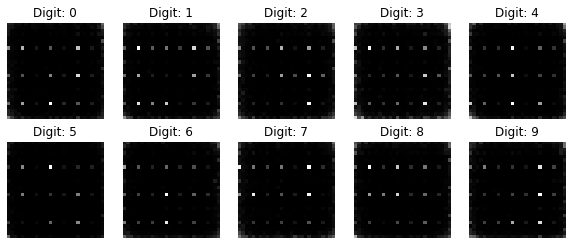

490 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


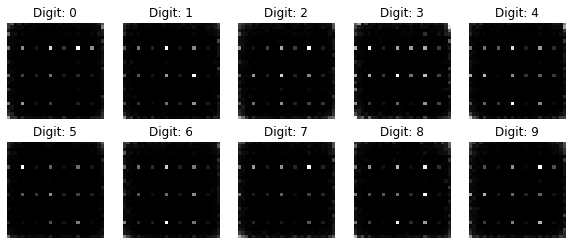

500 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


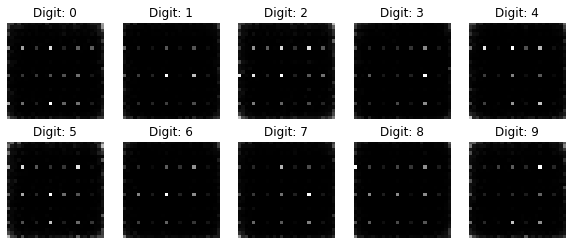

510 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


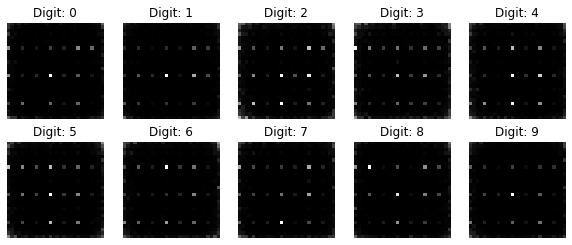

520 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


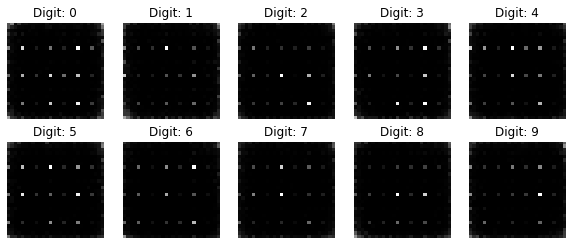

530 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


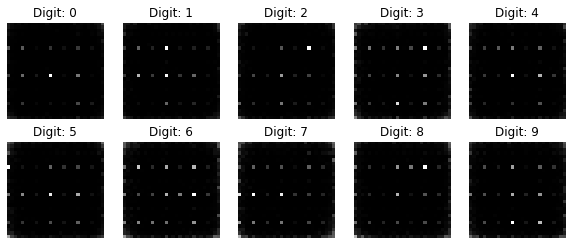

540 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


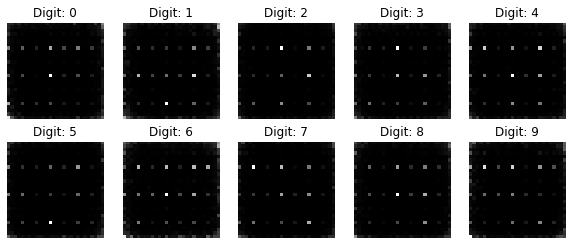

550 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


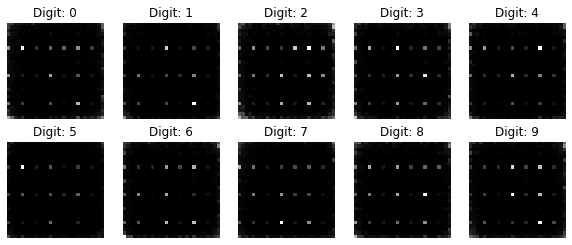

560 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


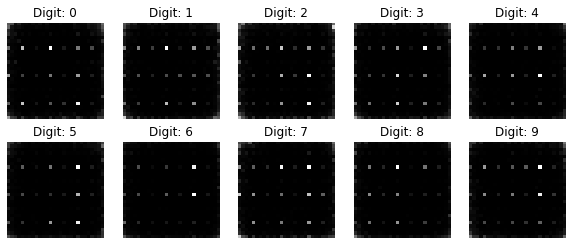

570 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


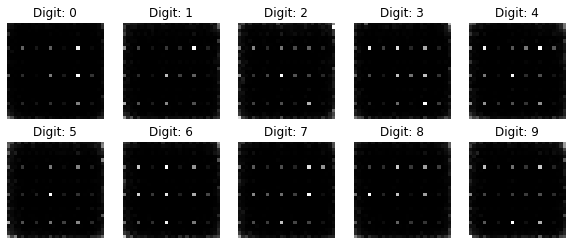

580 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


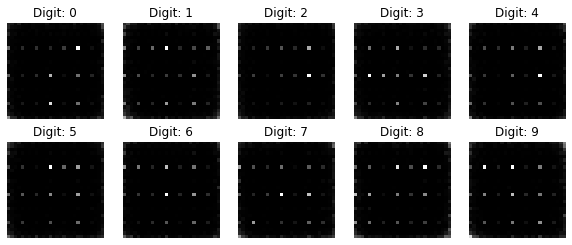

590 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


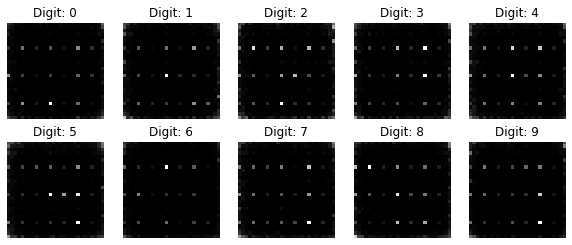

600 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


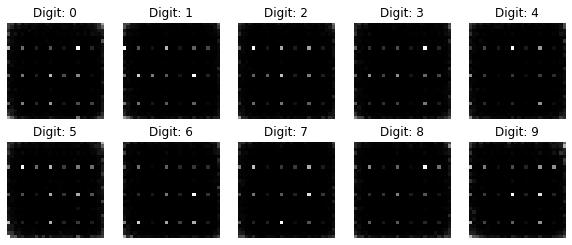

610 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


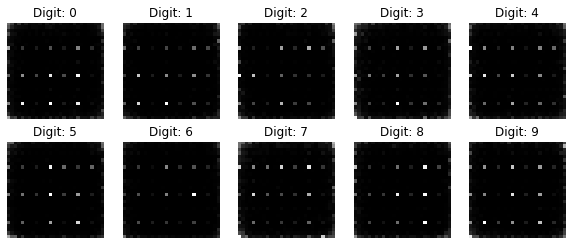

620 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


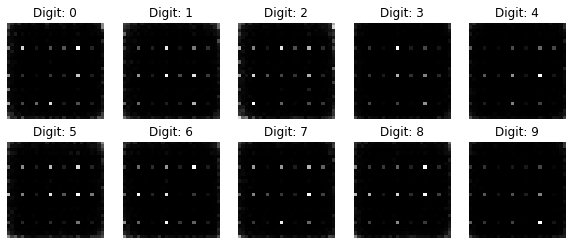

630 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


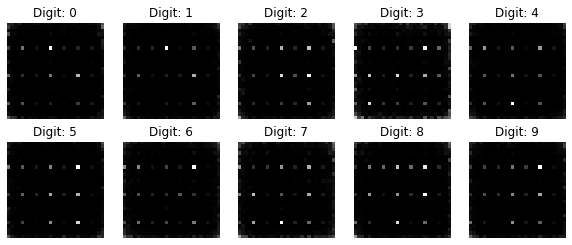

640 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


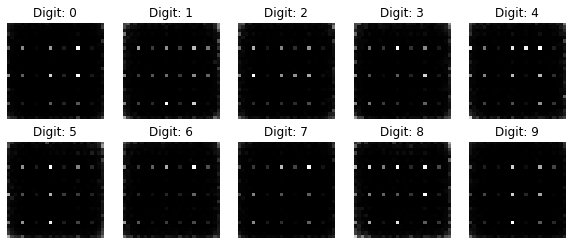

650 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


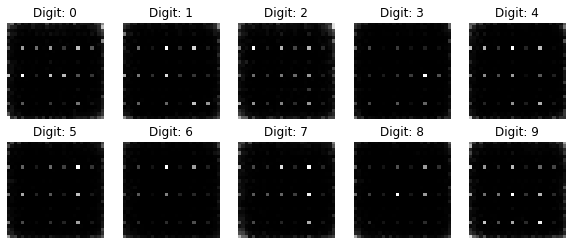

660 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


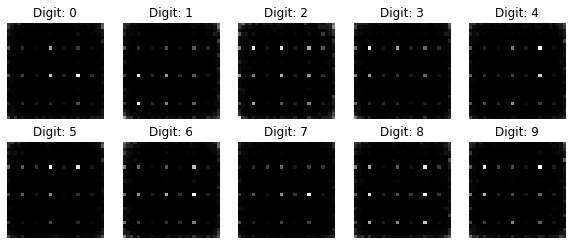

670 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


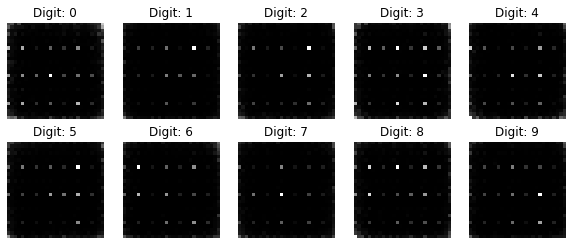

680 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


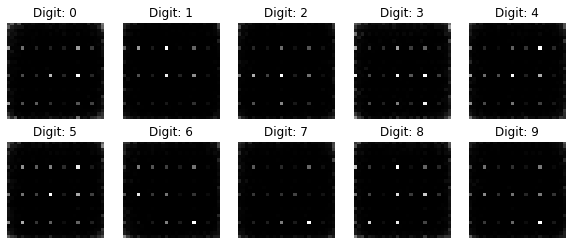

690 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


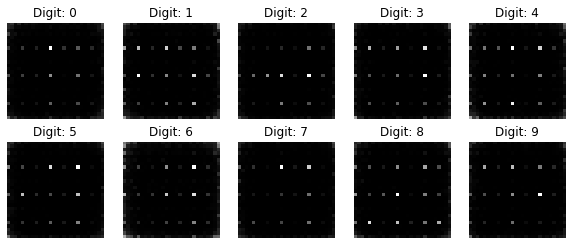

700 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


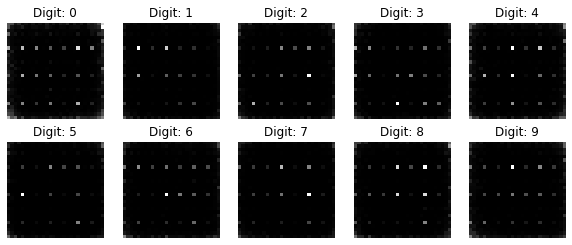

710 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


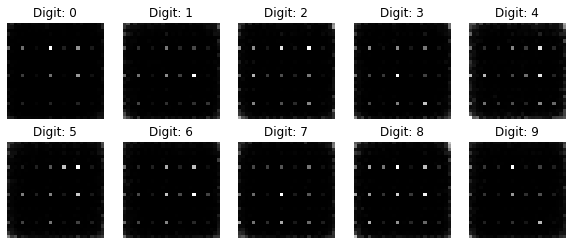

720 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


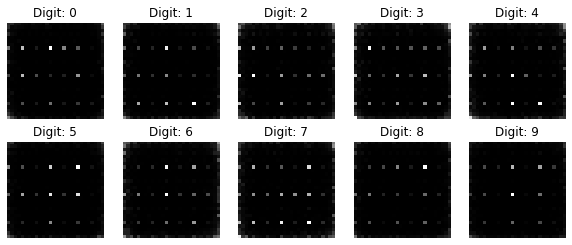

730 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


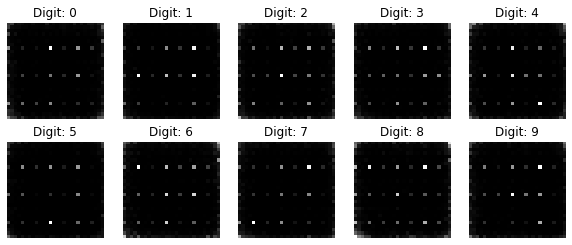

740 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


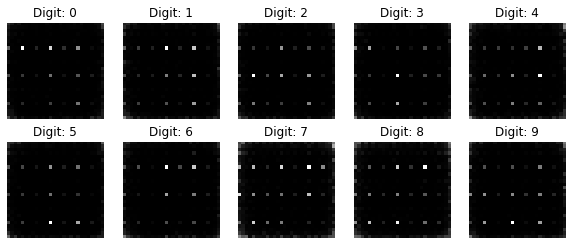

750 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


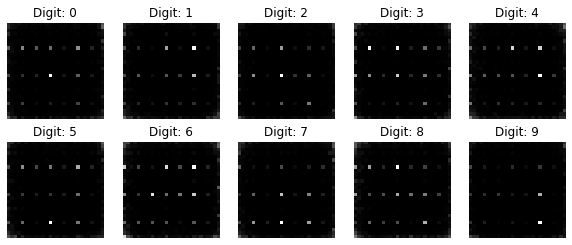

760 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


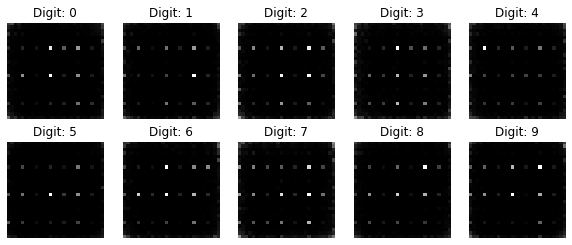

770 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


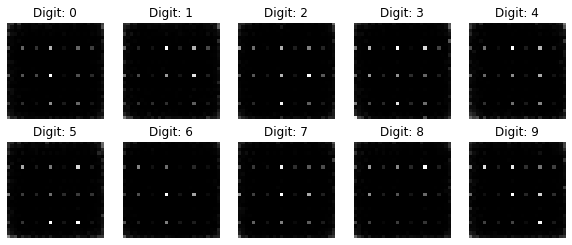

780 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


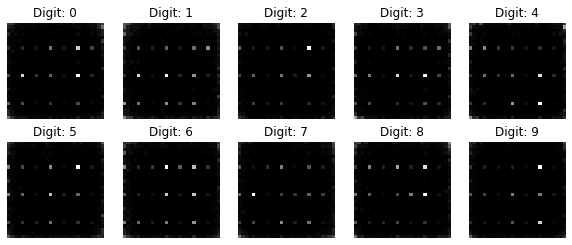

790 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


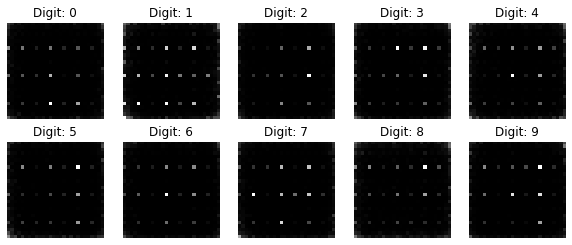

800 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


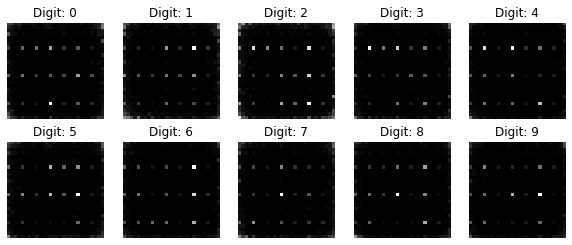

810 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


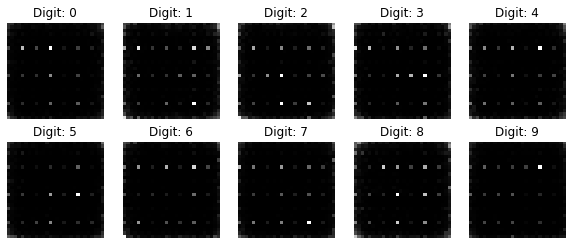

820 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


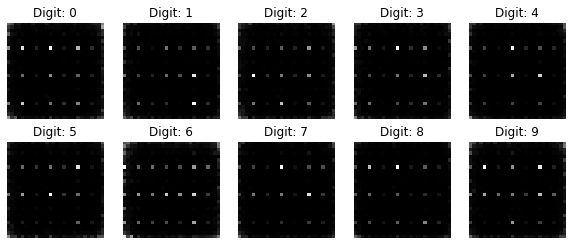

830 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


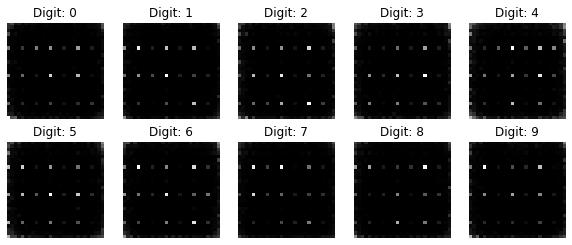

840 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


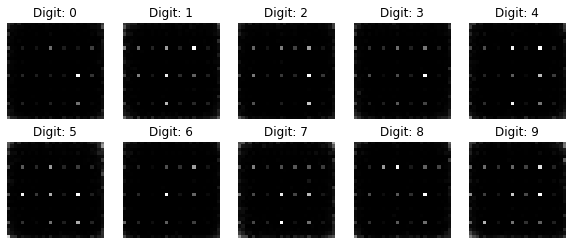

850 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


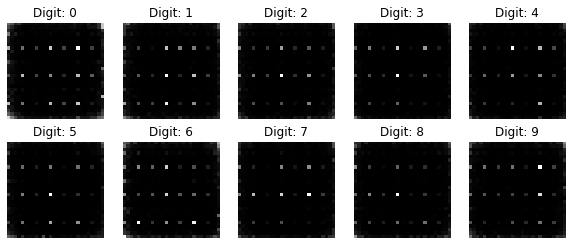

860 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


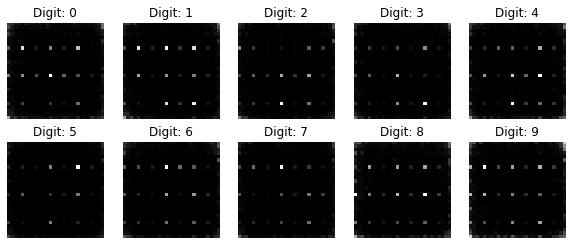

870 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


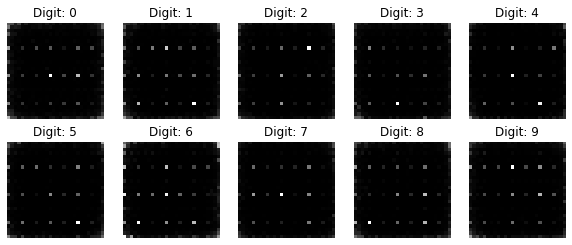

880 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


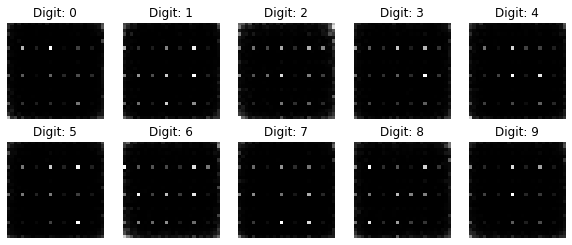

890 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


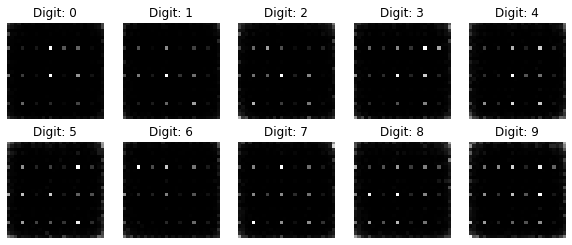

900 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


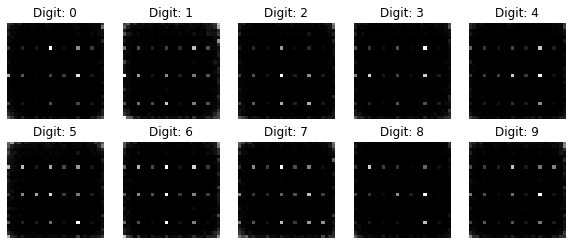

910 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


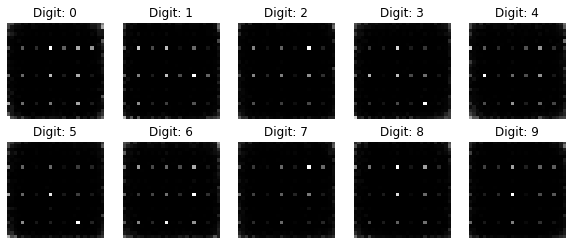

920 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


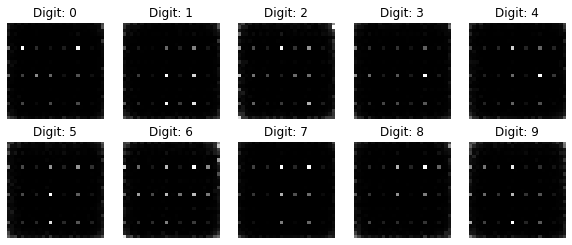

930 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


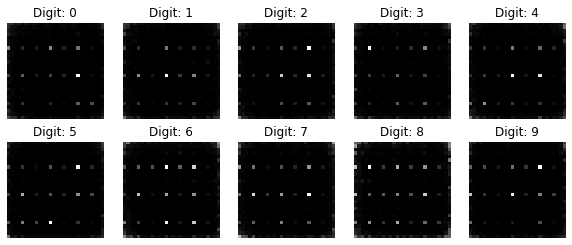

940 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


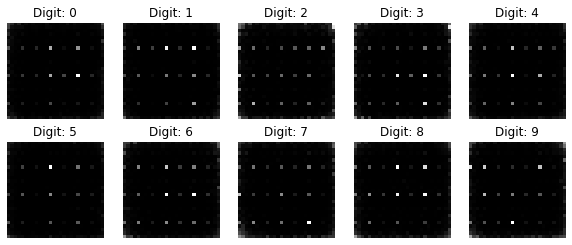

950 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


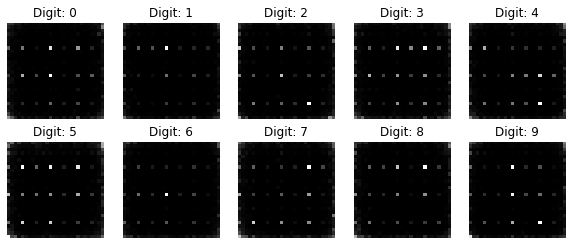

960 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


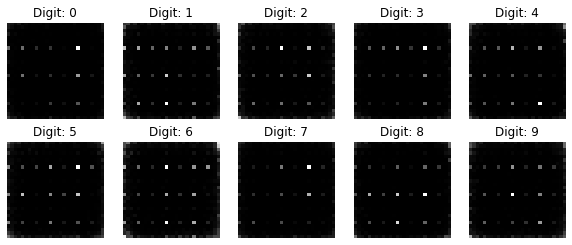

970 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


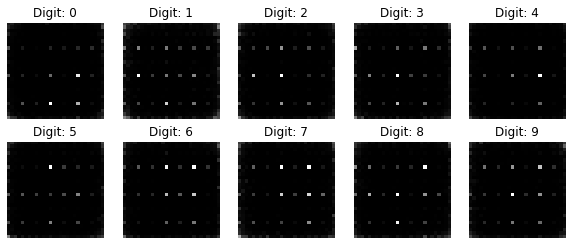

980 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


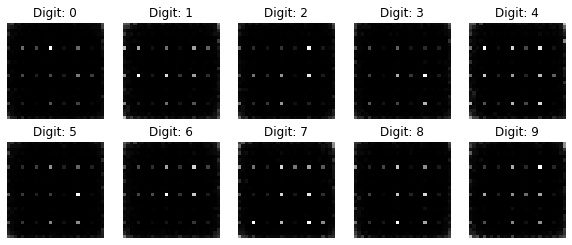

990 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


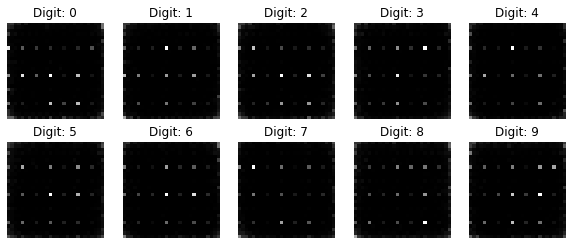

In [28]:
# Set some hyperparameters
params = {
    'n_epochs': 1000,
    'batch_size': 8,
    'sample_interval': 10,
    'z_dim': z_dim
}

# Train the WGAN for the specified number of iterations
losses, accuracies = train(x_train, y_train, params)

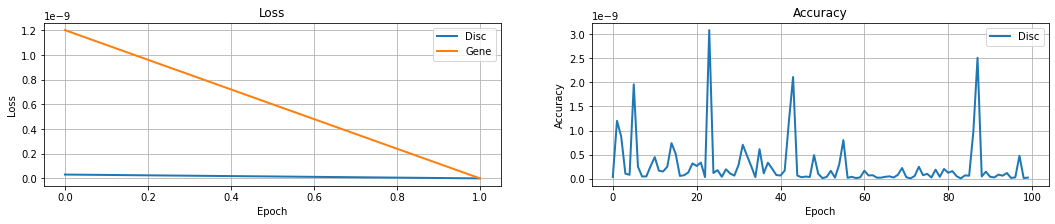

In [29]:
# Plot loss
plt.figure(figsize=(18, 3))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(losses[0], label='Disc', linewidth=2)
plt.plot(losses[1], label='Gene', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(accuracies, label='Disc', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

Modificando la escala de la perdida

In [20]:
def create_generator(z_dim):

  init = RandomNormal(stddev=0.02)    # weight initialization
  model = Sequential()
  model.add(Input(shape=(4, 4, z_dim + 1,)))

  model.add(Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer=init))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer=init))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, 3))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer=init))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(1, 7, padding='same', activation='tanh', kernel_initializer=init))

  return model

0 [D loss: 0.252598, acc.: 25.26%] [G loss: 0.499855]


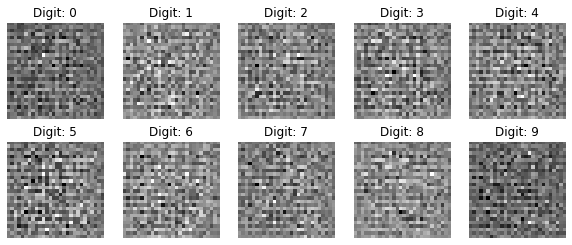

10 [D loss: 0.207608, acc.: 20.76%] [G loss: 0.414205]


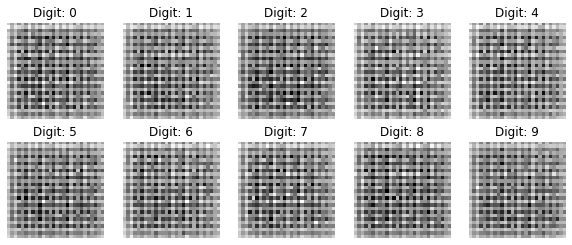

20 [D loss: 0.153849, acc.: 15.38%] [G loss: 0.263595]


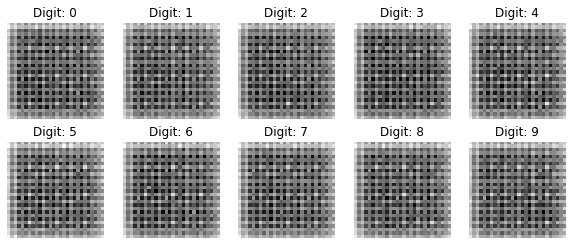

30 [D loss: 0.081985, acc.: 8.20%] [G loss: 0.128389]


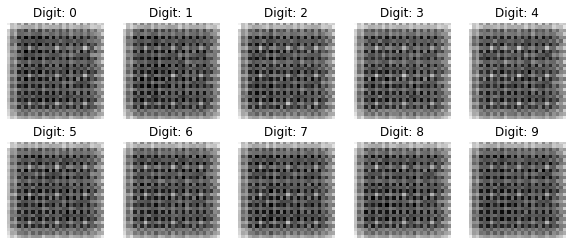

40 [D loss: 0.035451, acc.: 3.55%] [G loss: 0.040355]


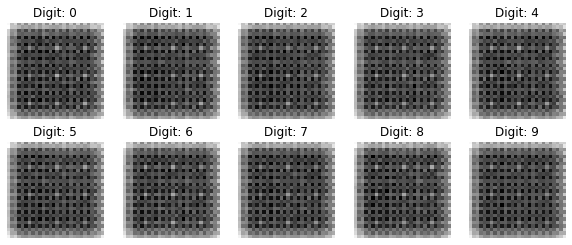

50 [D loss: 0.012226, acc.: 1.22%] [G loss: 0.011555]


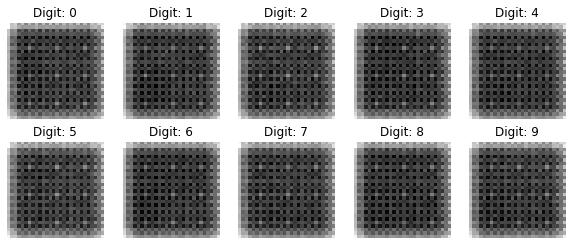

60 [D loss: 0.004124, acc.: 0.41%] [G loss: 0.002648]


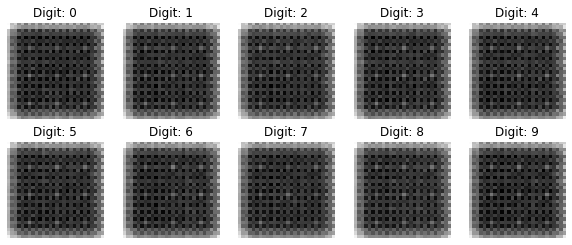

70 [D loss: 0.001772, acc.: 0.18%] [G loss: 0.000771]


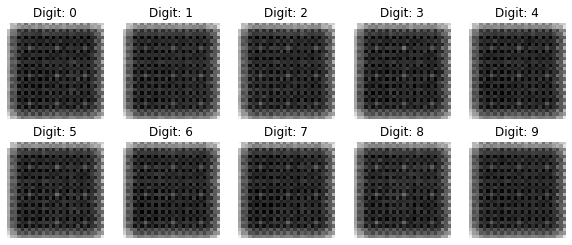

80 [D loss: 0.000536, acc.: 0.05%] [G loss: 0.000190]


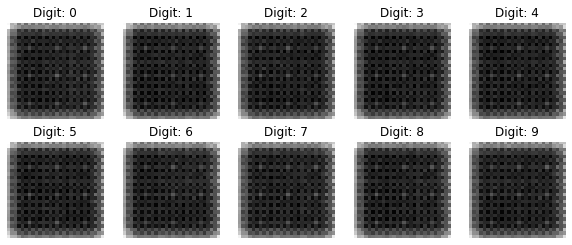

90 [D loss: 0.000174, acc.: 0.02%] [G loss: 0.000030]


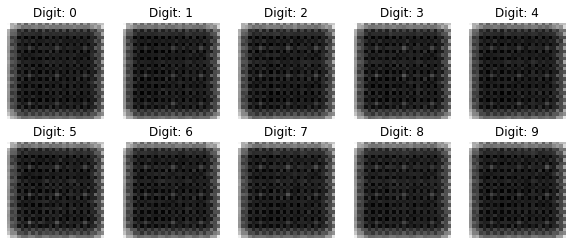

100 [D loss: 0.000029, acc.: 0.00%] [G loss: 0.000012]


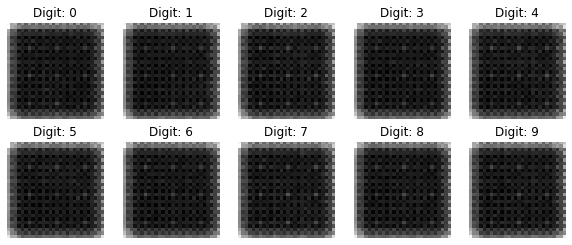

110 [D loss: 0.000011, acc.: 0.00%] [G loss: 0.000003]


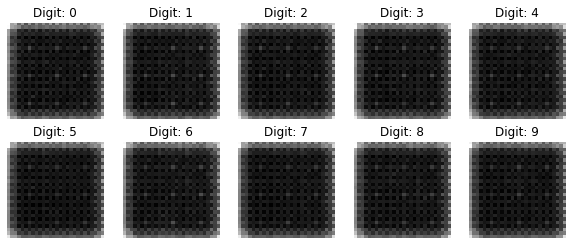

120 [D loss: 0.000002, acc.: 0.00%] [G loss: 0.000000]


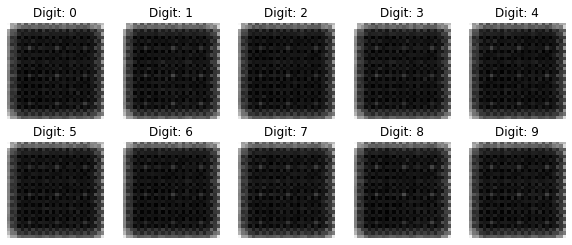

130 [D loss: 0.000002, acc.: 0.00%] [G loss: 0.000000]


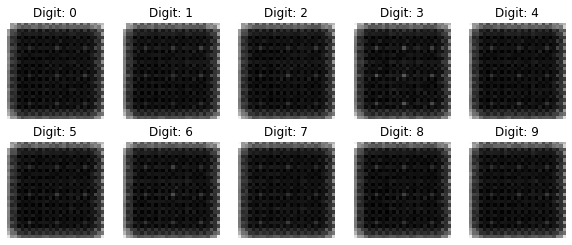

140 [D loss: 0.000001, acc.: 0.00%] [G loss: 0.000000]


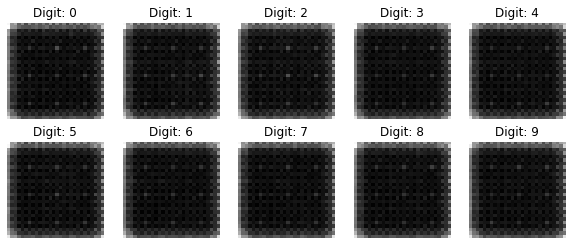

150 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


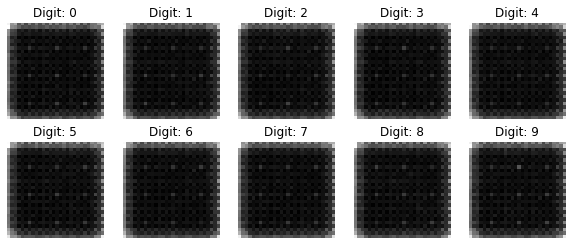

160 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


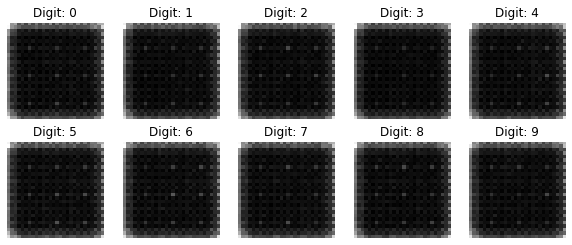

170 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


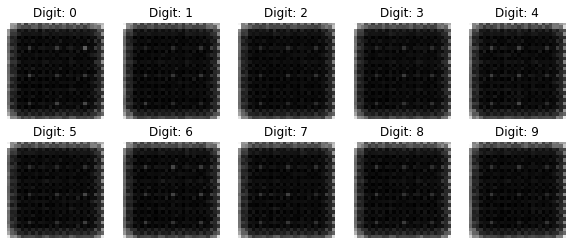

180 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


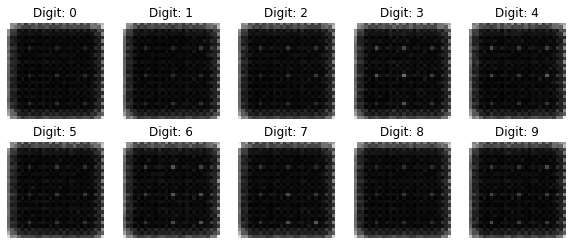

190 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


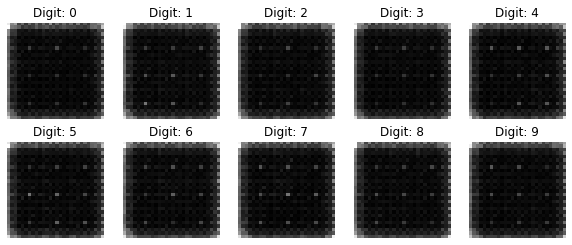

200 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


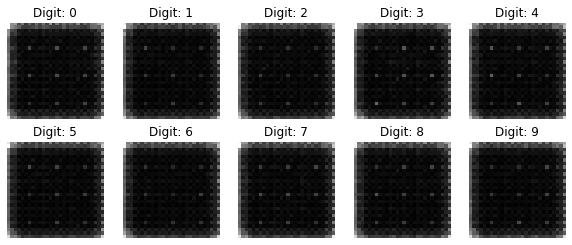

210 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


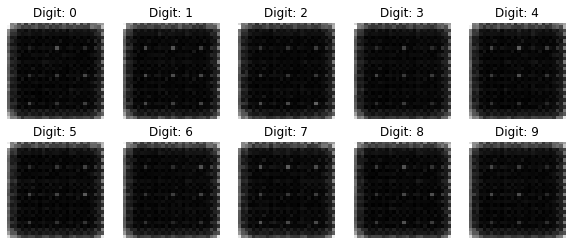

220 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


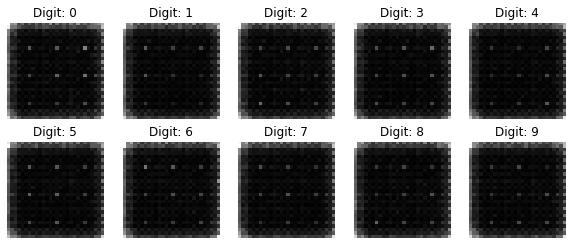

230 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


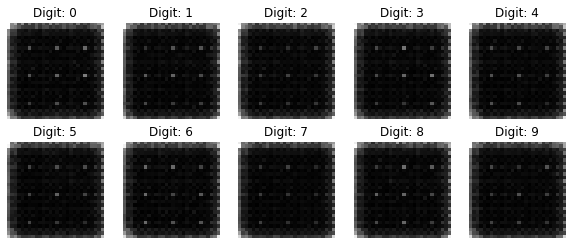

240 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


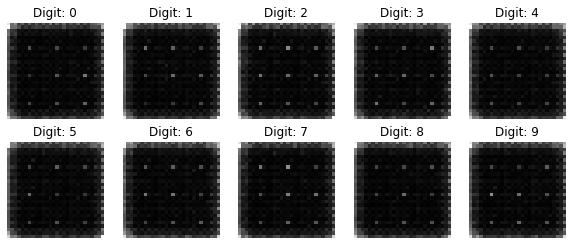

250 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


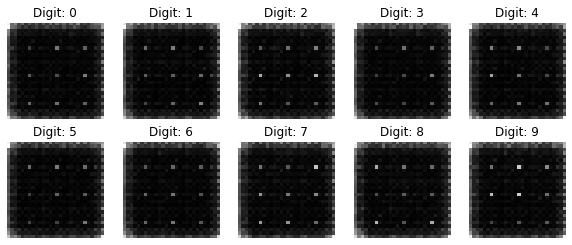

260 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


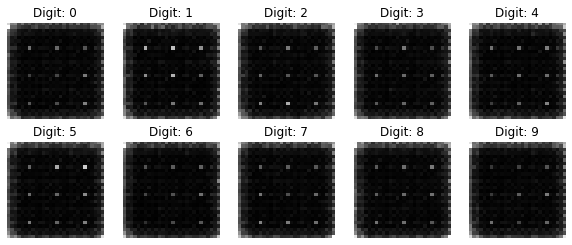

270 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


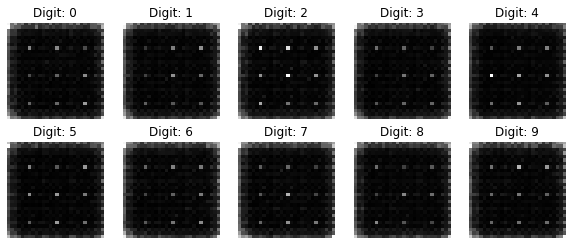

280 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


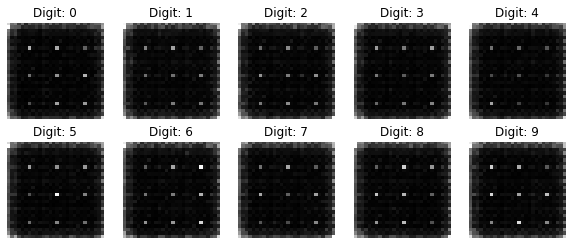

290 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


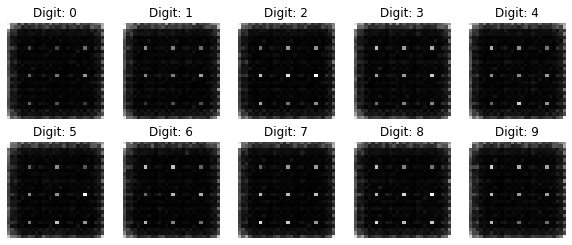

300 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


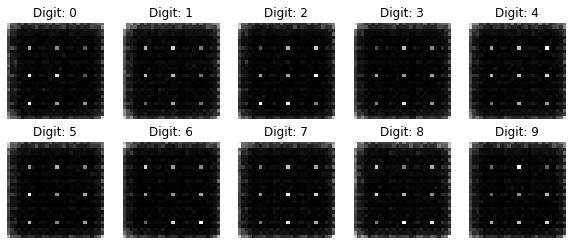

310 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


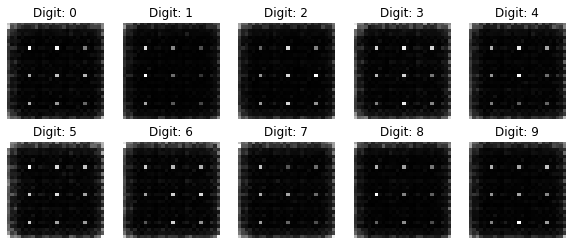

320 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


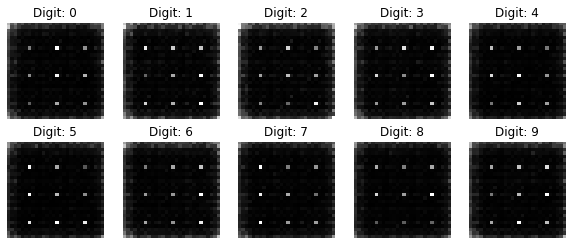

330 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


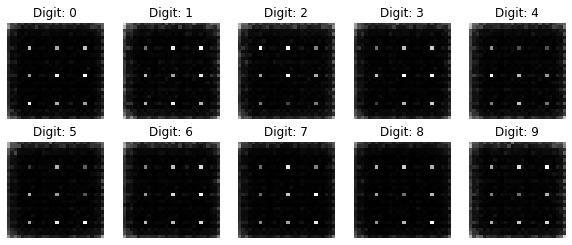

340 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


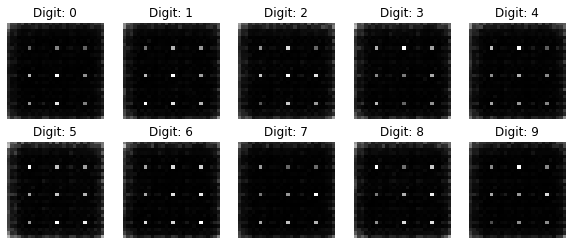

350 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


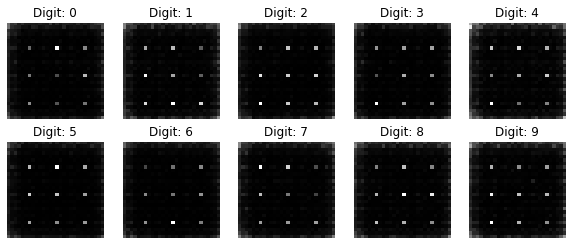

360 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


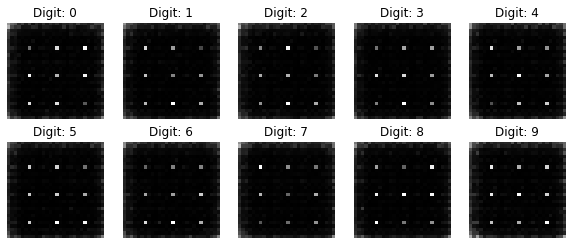

370 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


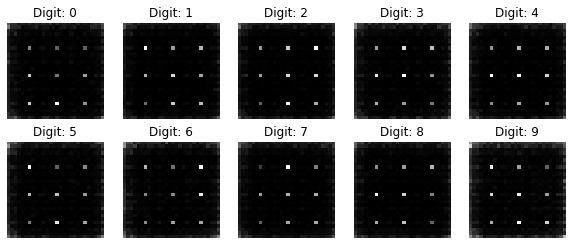

380 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


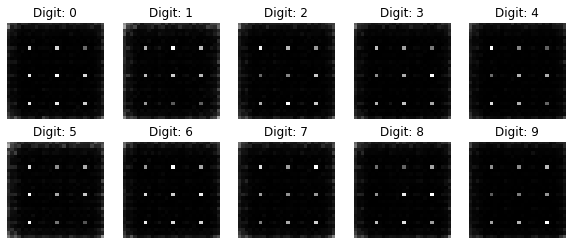

390 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


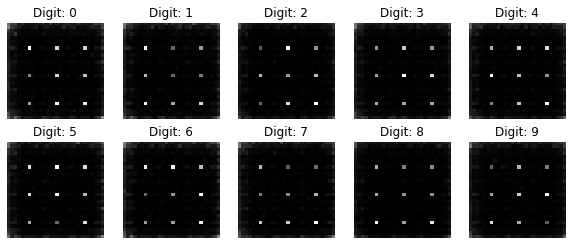

400 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


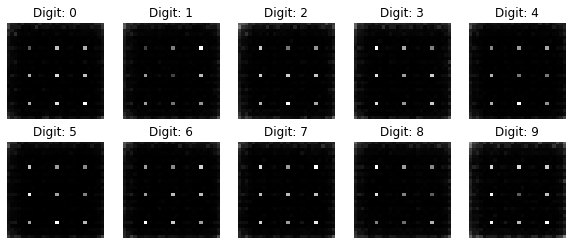

410 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


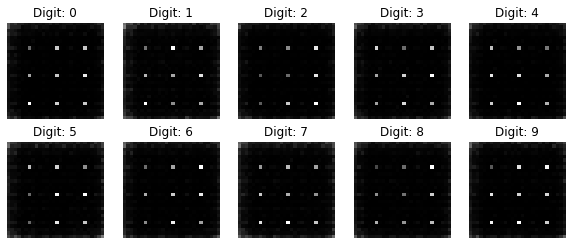

420 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


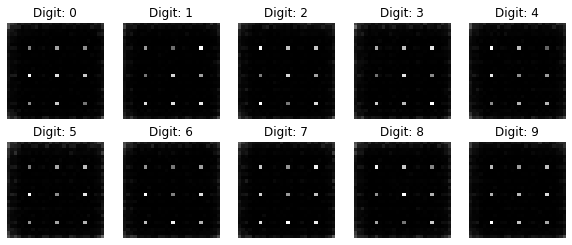

430 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


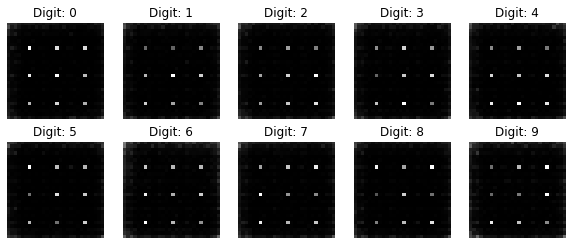

440 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


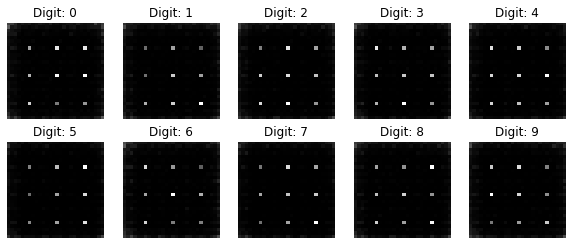

450 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


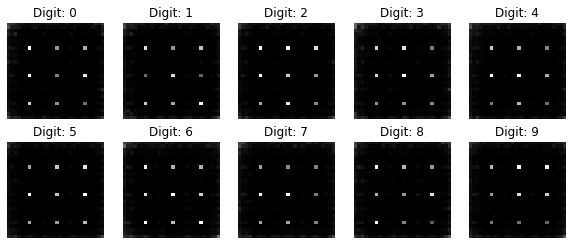

460 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


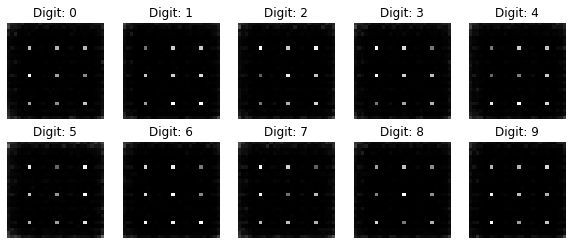

470 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


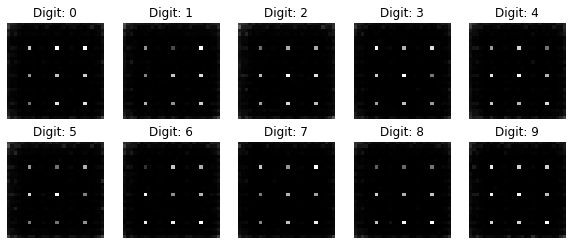

480 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


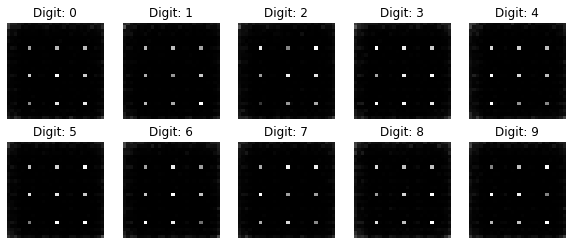

490 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


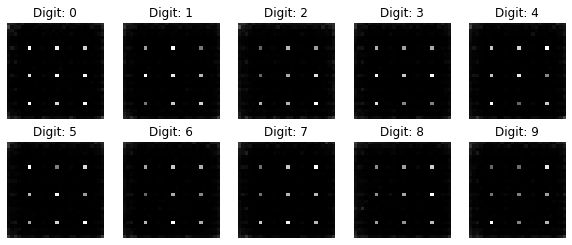

500 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


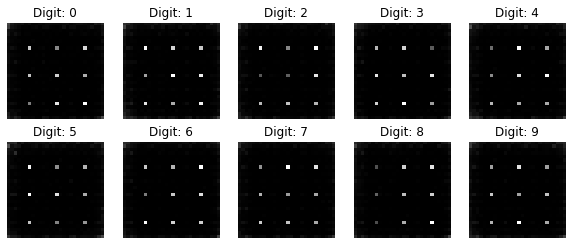

510 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


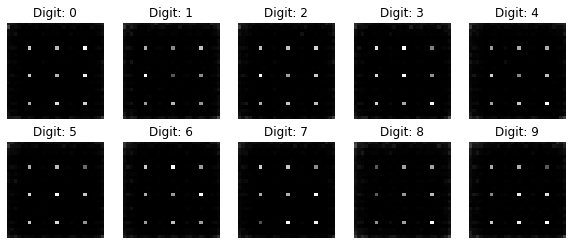

520 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


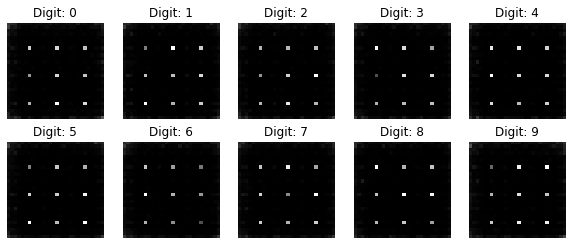

530 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


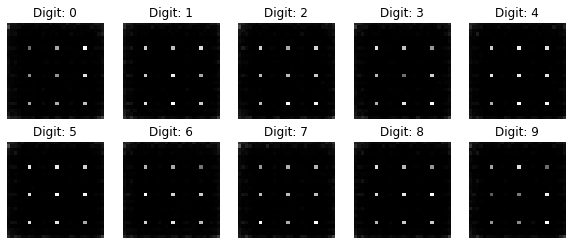

540 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


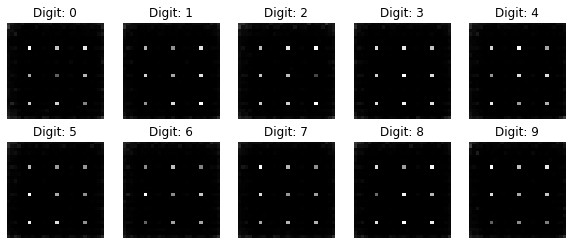

550 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


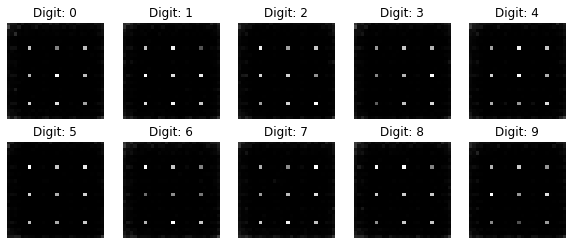

560 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


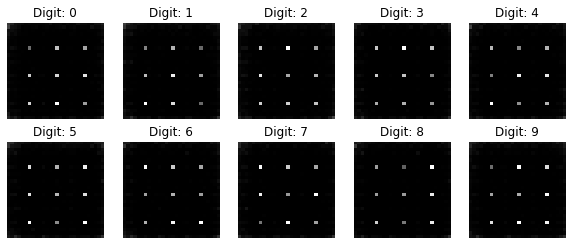

570 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


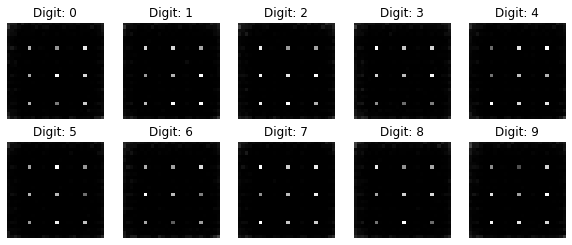

580 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


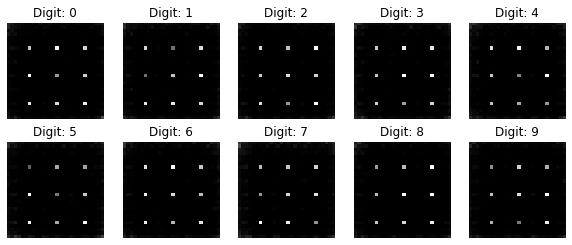

590 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


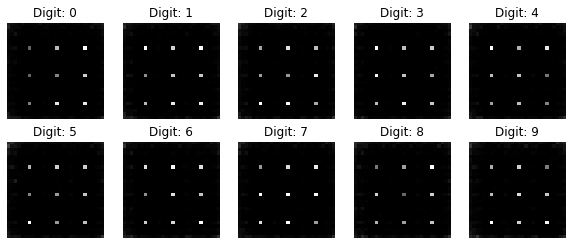

600 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


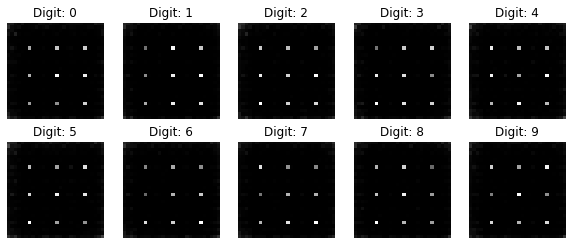

610 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


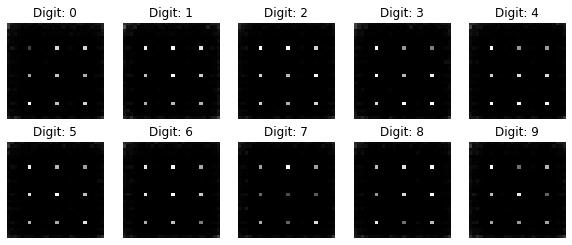

620 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


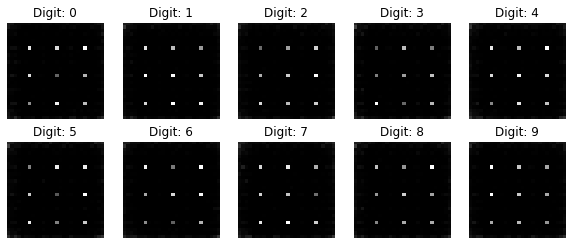

630 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


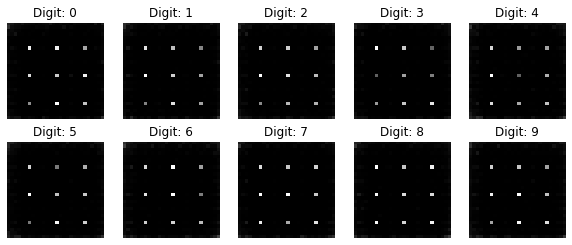

640 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


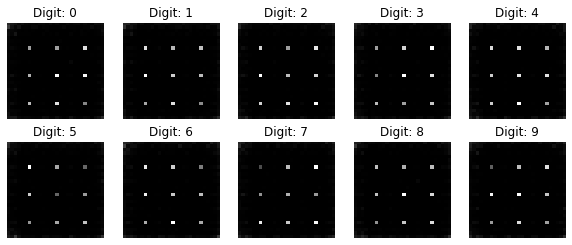

650 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


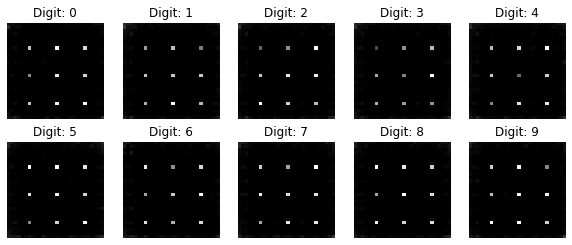

660 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


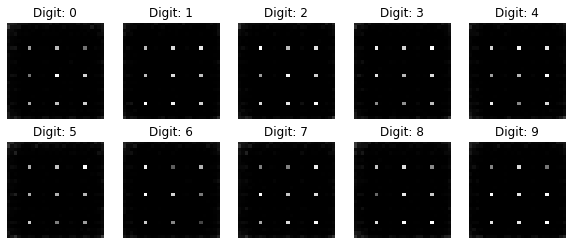

670 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


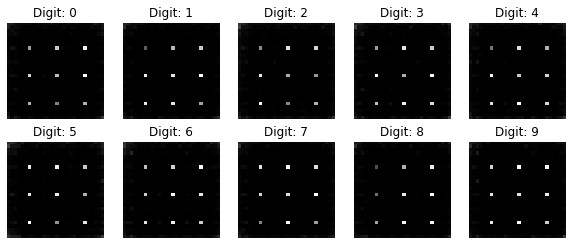

680 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


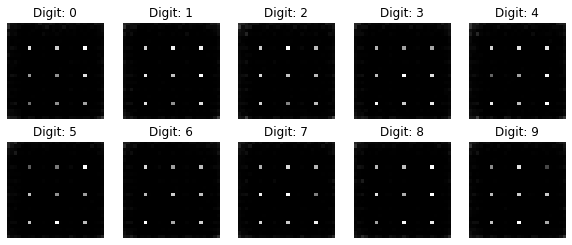

690 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


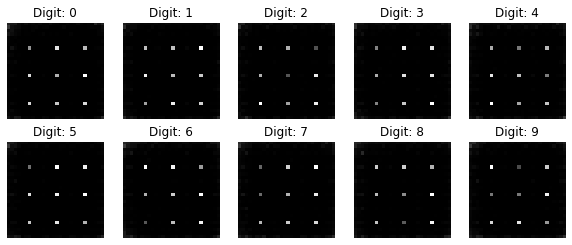

700 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


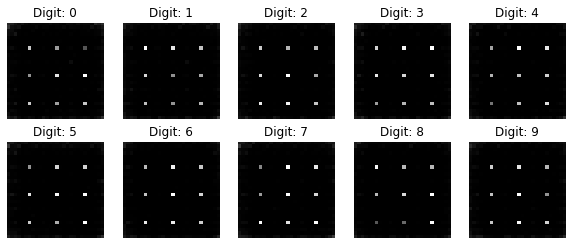

710 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


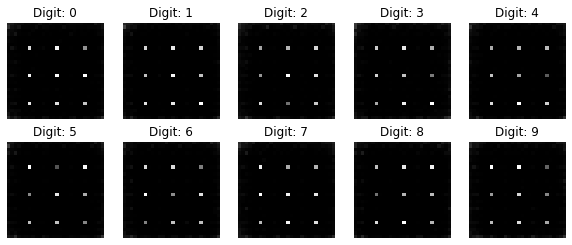

720 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


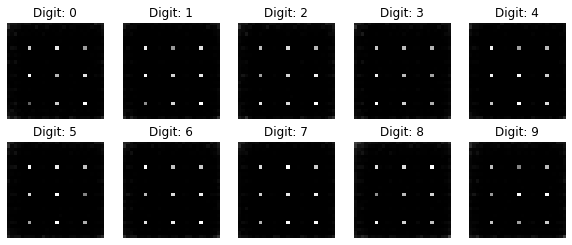

730 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


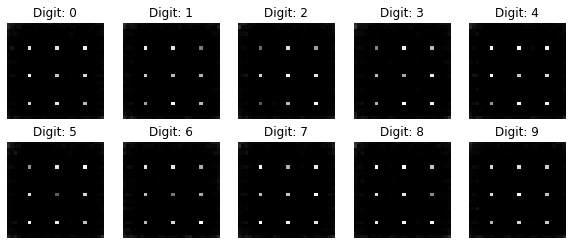

740 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


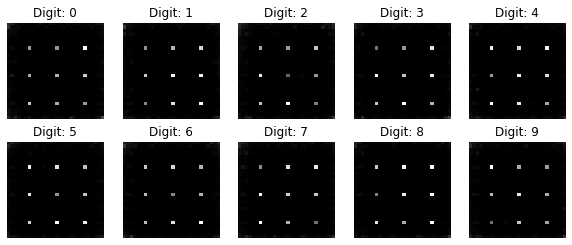

750 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


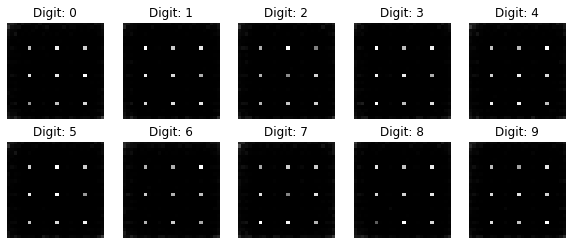

760 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


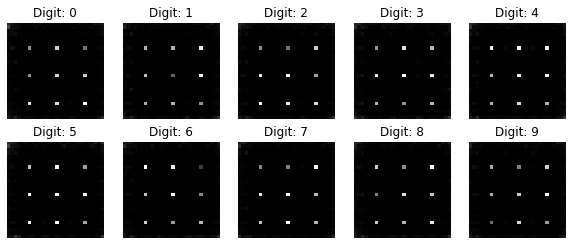

770 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


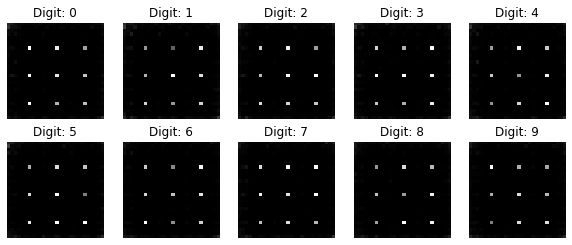

780 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


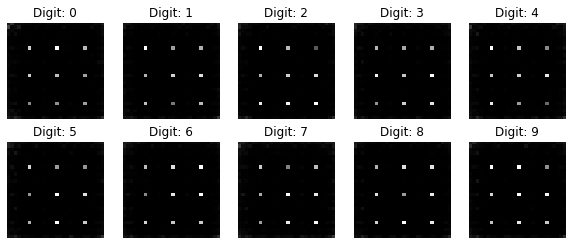

790 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


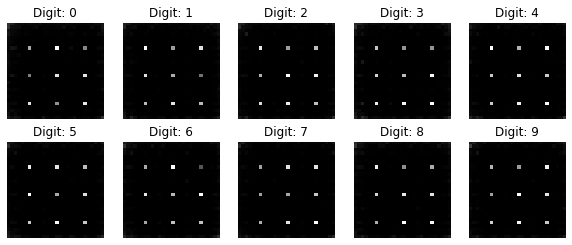

800 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


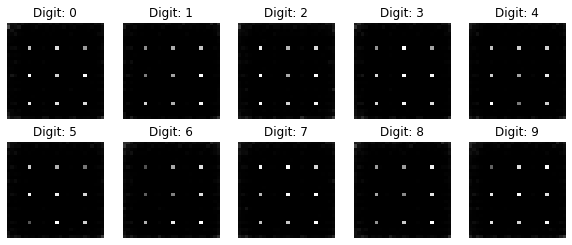

810 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


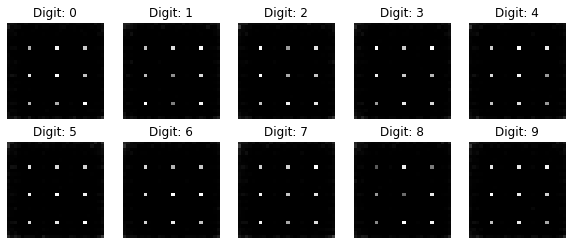

820 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


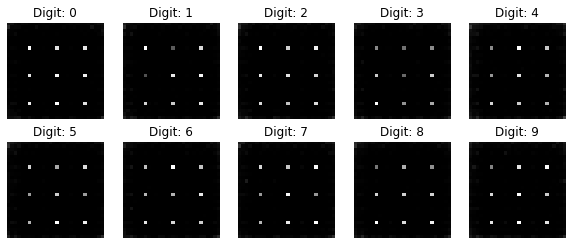

830 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


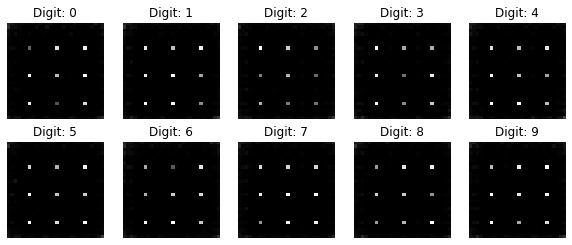

840 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


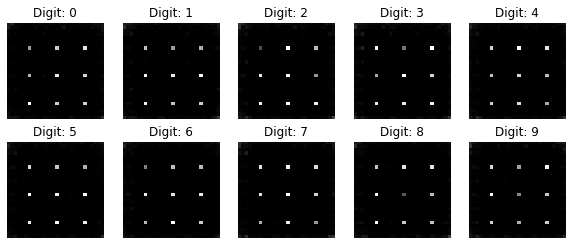

850 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


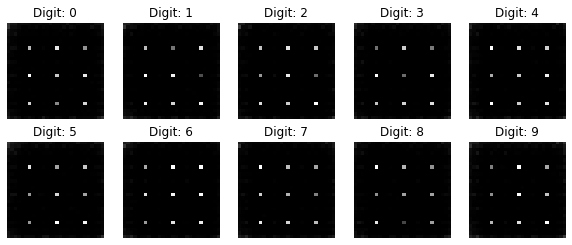

860 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


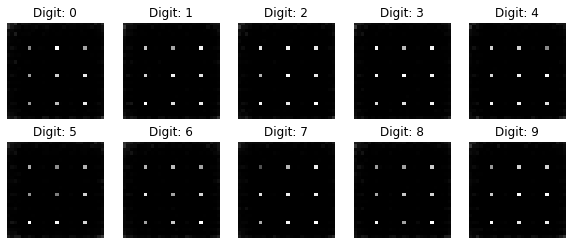

870 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


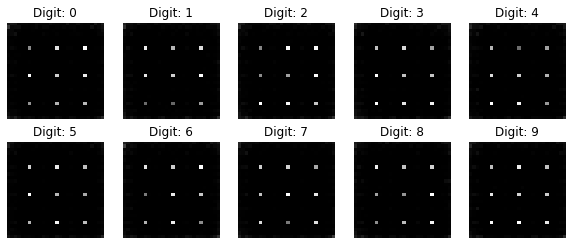

880 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


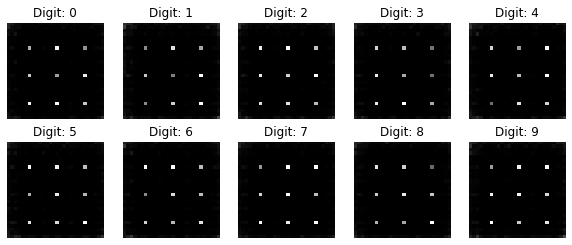

890 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


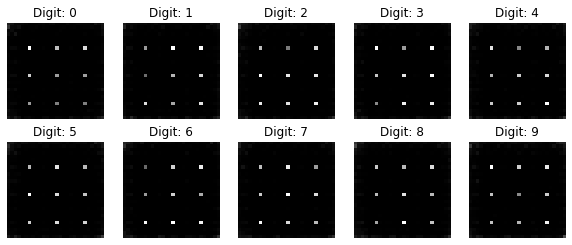

900 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


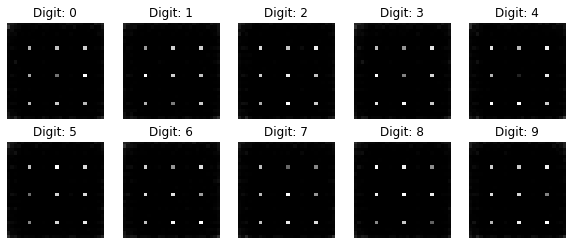

910 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


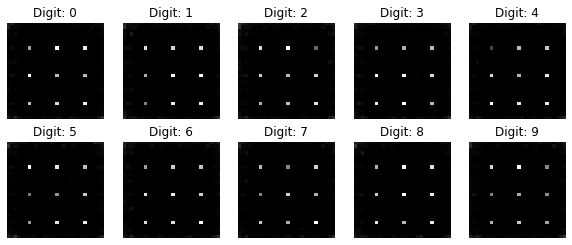

920 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


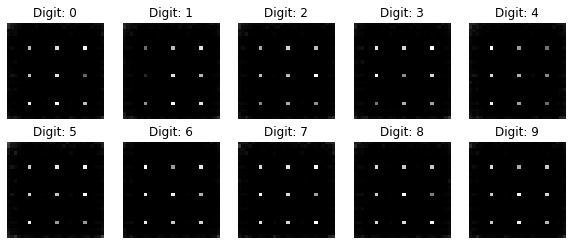

930 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


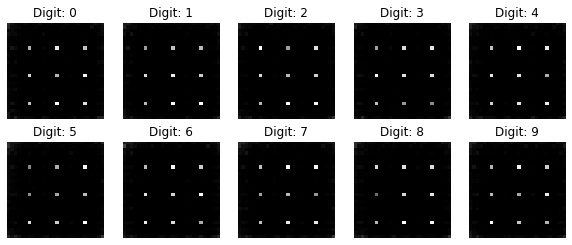

940 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


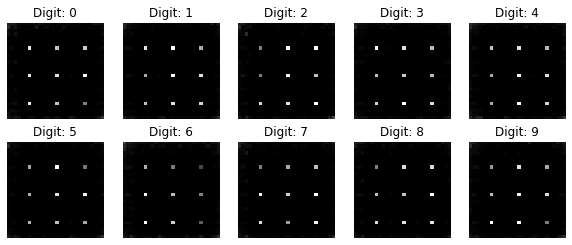

950 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


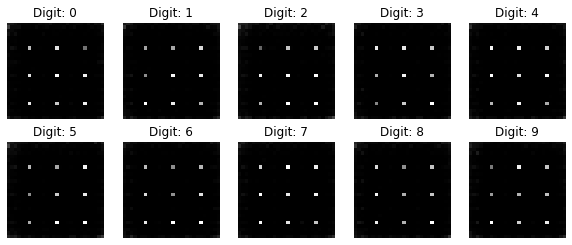

960 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


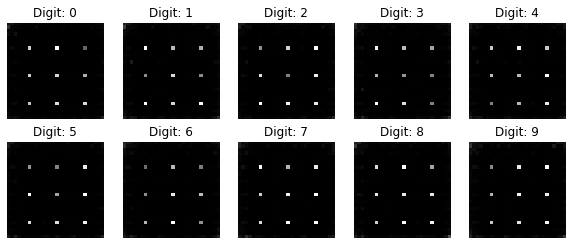

970 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


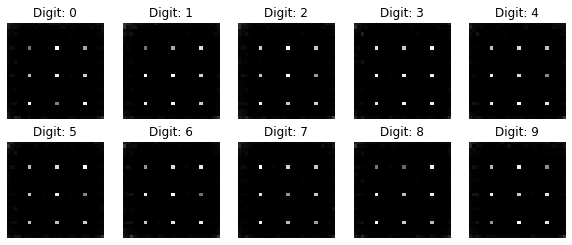

980 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


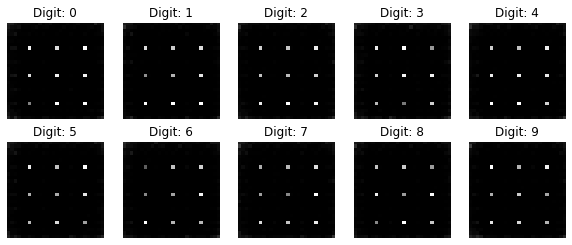

990 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000]


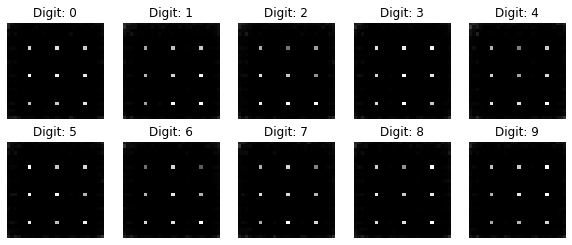

In [22]:
# Set some hyperparameters
params = {
    'n_epochs': 1000,
    'batch_size': 8,
    'sample_interval': 10,
    'z_dim': z_dim
}

# Train the WGAN for the specified number of iterations
losses, accuracies = train(x_train, y_train, params)

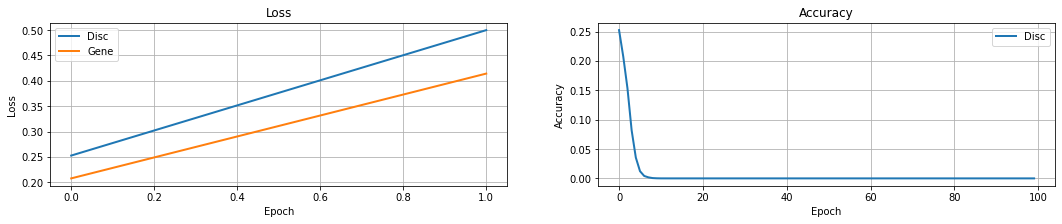

In [23]:
# Plot loss
plt.figure(figsize=(18, 3))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(losses[0], label='Disc', linewidth=2)
plt.plot(losses[1], label='Gene', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(accuracies, label='Disc', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()